<!-- \***\*============================GRAPH PREPROCESSING============================** -->


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pickle

# Define the Edge class
class Edge:
    def __init__(self, u, v, weight):
        self.u = u
        self.v = v
        self.weight = weight
def preprocess_graph(G):
    # assuming 'weight' is the name of the attribute for edge weights
    return dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))

In [3]:


# # Read the file and create edges with random weights
# file_path = 'small_dataset.txt'  # Replace with the actual file path
# edges = []
# with open(file_path, 'r') as file:
#     file_contents = file.readlines()
#     num_lines = len(file_contents)
#     for i, line in enumerate(file_contents):
#         node1, node2 = map(int, line.split())
#         weight = float(randint(1, 99)) + (1 / (2 ** (num_lines + i + 1)))
#     # Ensure the weight is displayed with full precision
#         # print(f"Weight: {weight:.50f}")
#         edges.append(Edge(node1, node2, weight))

# # Create a NetworkX graph and add edges
# G = nx.Graph()
# for edge in edges:
#     G.add_edge(edge.u, edge.v, weight=edge.weight)

# # Preprocess the graph
# D = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))

# # Create a new figure with a larger size
# plt.figure(figsize=(60, 60))

# # Draw the graph using the spring_layout
# pos = nx.spring_layout(G)
# nx.draw(G, pos, with_labels=True, node_color="yellow", node_size=300, edge_color="gray")

# # Draw edge labels
# edge_labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

# plt.show()

In [4]:
# Load G and D from the local files
with open('graph.pkl', 'rb') as f:
    G = pickle.load(f)
with open('distances.pkl', 'rb') as f:
    D = pickle.load(f)
with open('shortest_paths.pkl', 'rb') as f:
    shortest_paths = pickle.load(f) 

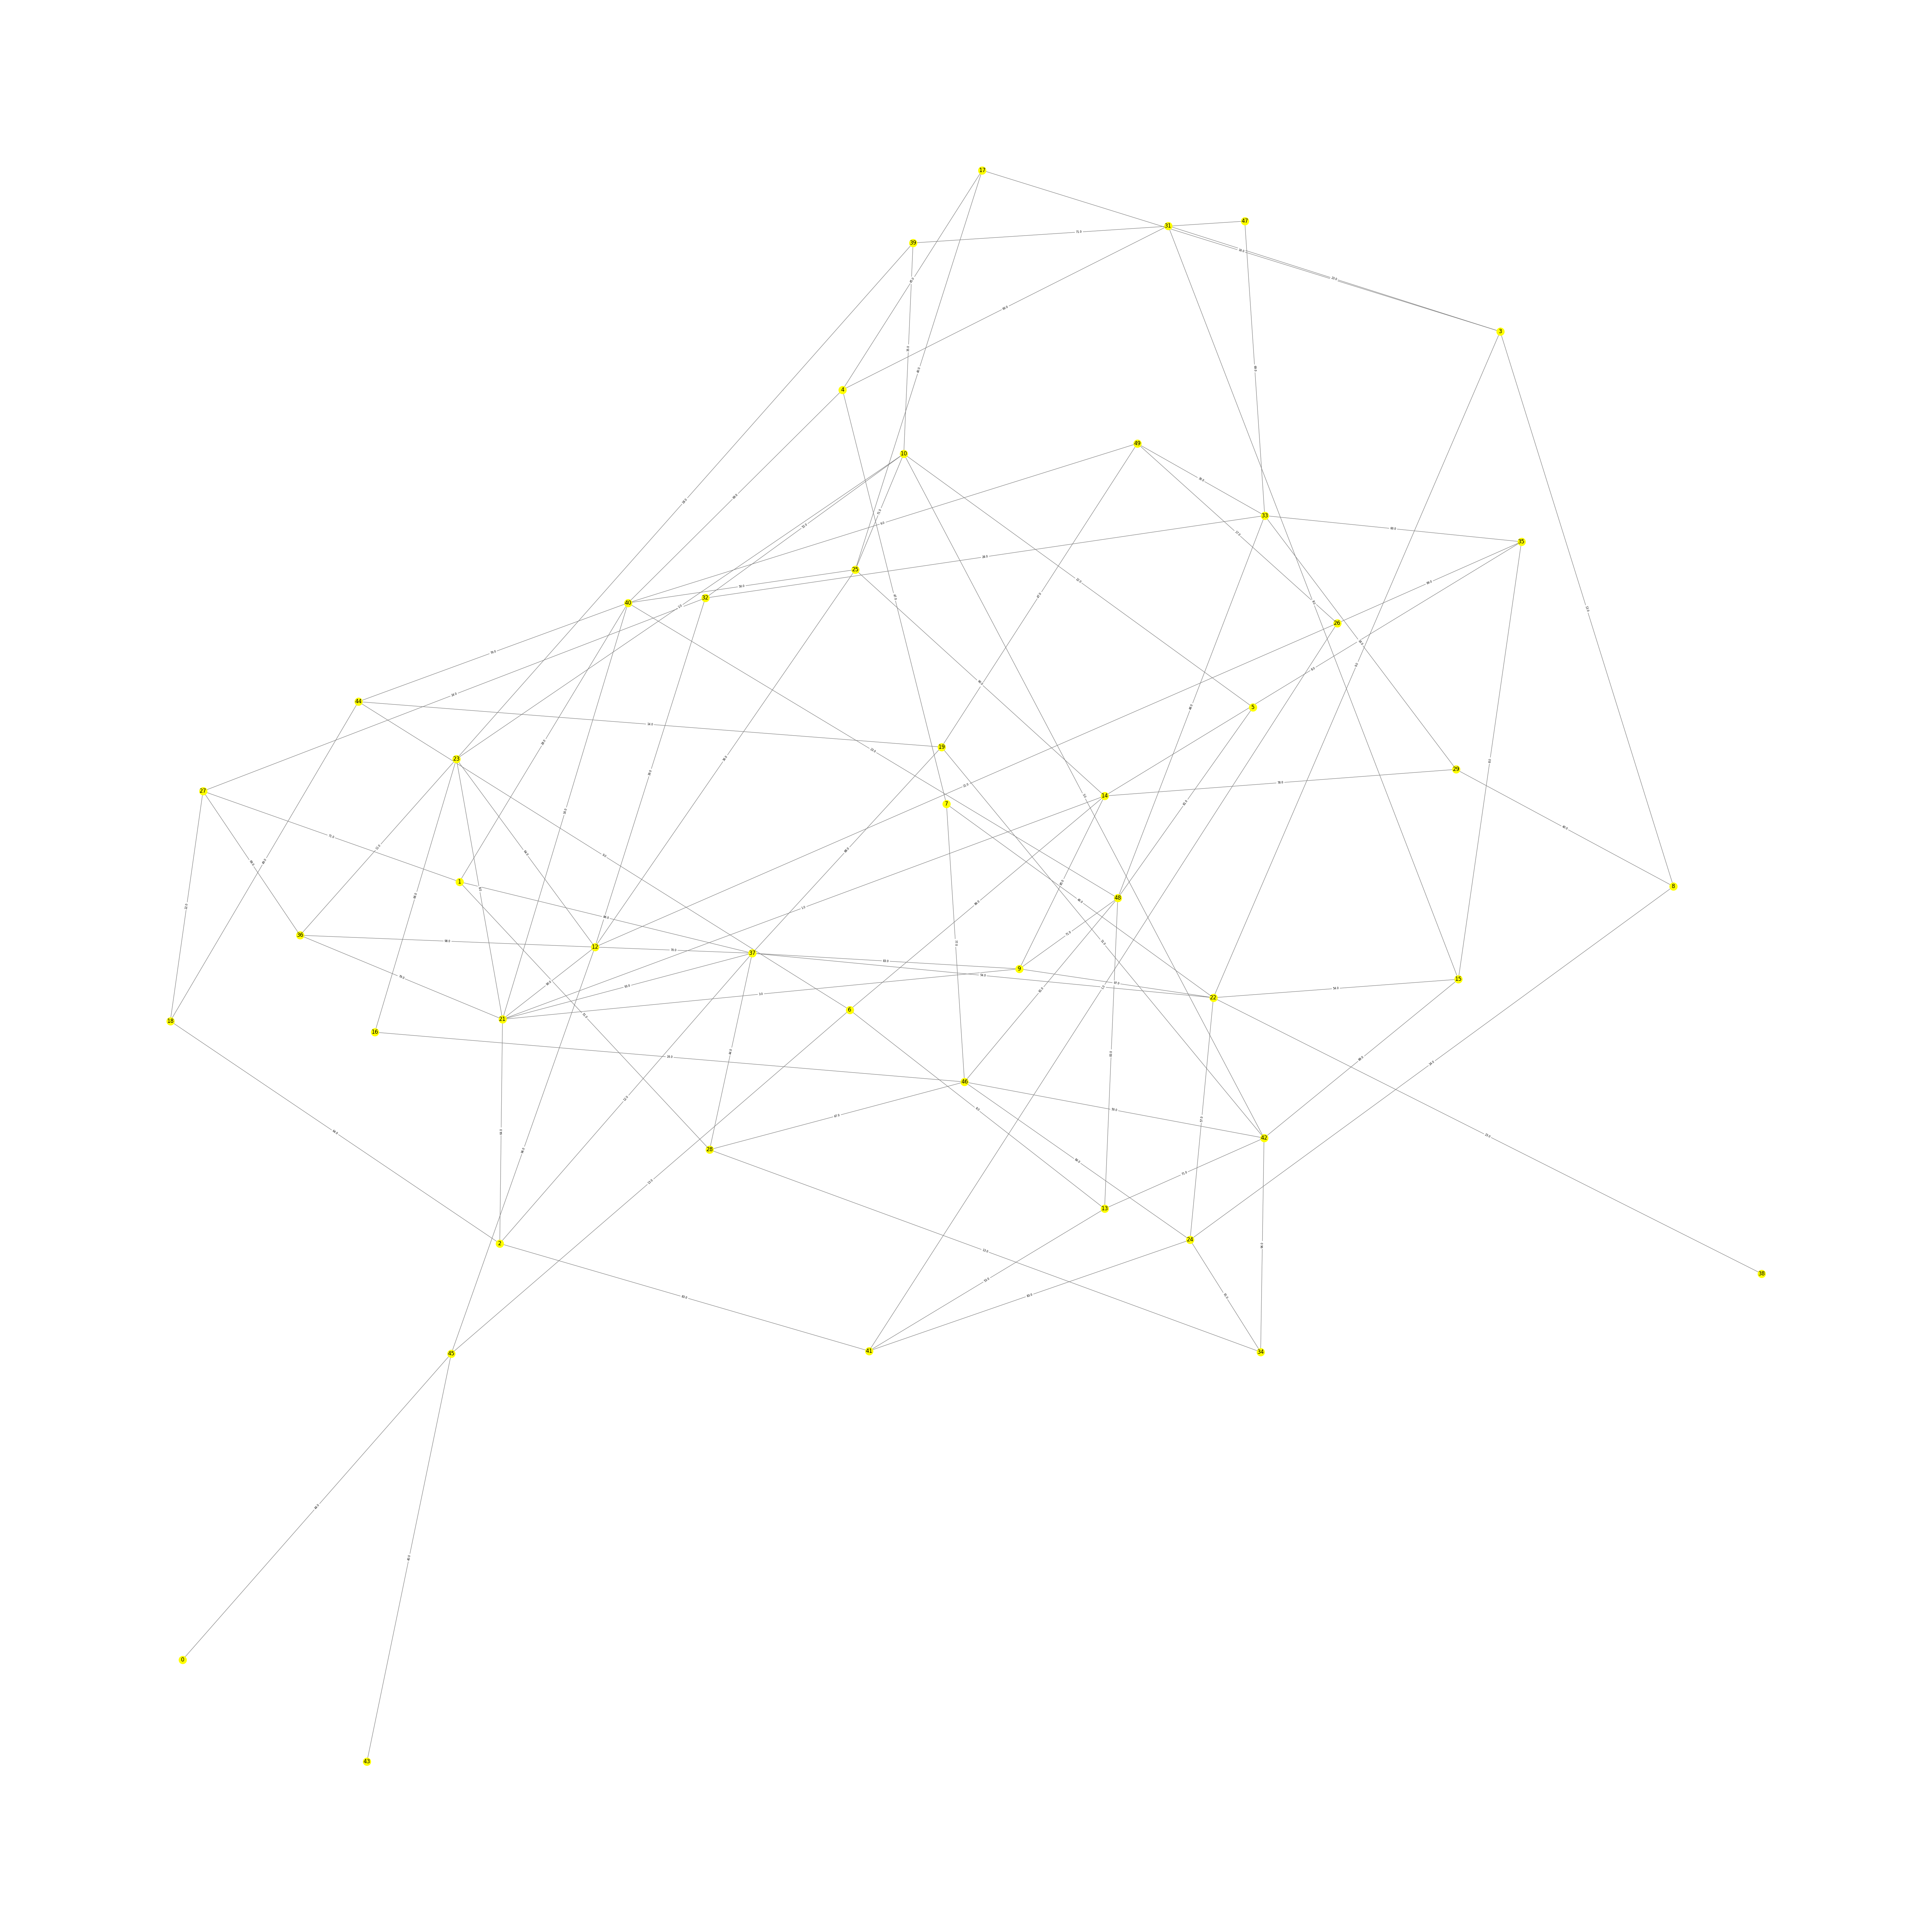

In [5]:
# Create a new figure with a larger size
plt.figure(figsize=(60, 60))

# Draw the graph using the spring_layout
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color="yellow", node_size=300, edge_color="gray")

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

plt.show()

<!-- =================================== Distance Oracle ===================================== -->


In [6]:
class DistanceOracle:
    def __init__(self,distances=None):
        if distances is None:
            self.data = {}
        else:
            self.data = distances
    def get_distance(self, u, v):
        return self.data.get(u, {}).get(v, float("inf"))
    def __getitem__(self, key):
        return self.data[key]
    def add_distance(self, u, v, distance):
        if u not in self.data:
            self.data[u] = {}
        self.data[u][v] = distance


In [7]:

distance_oracle = DistanceOracle(D)

<!-- \*\*---------------------------------SHORTEST PATH function and Store------------------------------- -->


In [8]:
# import networkx as nx

# def store_shortest_paths(G):
#     # Use NetworkX's built-in function to compute all pairs shortest paths
#     all_pairs_paths = dict(nx.all_pairs_dijkstra_path(G, weight='weight'))
    
#     # Flatten the dictionary to match the desired output format
#     shortest_paths = {}
#     for u, paths in all_pairs_paths.items():
#         for v, path in paths.items():
#             shortest_paths[(u, v)] = path
    
#     return shortest_paths

# # Example usage
# shortest_paths = store_shortest_paths(G)



In [9]:
# with open('shortest_paths.pkl', 'wb') as f:
#     pickle.dump(shortest_paths, f)

<!-- ---------------------------------POWER_OF_2 FUNCTION-------------------------------- -->


In [10]:
import math

def nearest_power_of_2(x):
    if x <= 0:
        return 0 # Return 1 for non-positive input
    elif math.isinf(x):
        return float("inf")  # Return infinity for infinite input
    else:
        return 2 ** math.floor(math.log2(x))

<!-- --------------------------------FIND_JUMP FUNCTION-------------------------------- -->


In [11]:
def FINDJUMP(P, F):
    X = []  # Initialize X with s
    x = P[0]
    X.append(x)
    # F = list(F)
    # vertices = [F.u , F.v]
   
    if(nearest_power_of_2(
        distance_oracle.get_distance(x, F[0]))< nearest_power_of_2(distance_oracle.get_distance(x, F[1]))):
            u = F[0]
    else:
        u = F[1]
    
    # u = min(F, key=lambda v: nearest_power_of_2(
    #     distance_oracle.get_distance(x, v)))
    # print(u)
    while True:
        # Find y, the first vertex on P[x, t] at distance >= max{1, (xu)^2} from x
        distance = max(1, nearest_power_of_2(
            distance_oracle.get_distance(x, u)))
        # print(distance)
        y = None
        for vertex in P[P.index(x)+1:]:
            if distance_oracle.get_distance(x, vertex) >= distance:
                y = vertex
                break
        if y is not None:
            X.append(y)
            x = y
        else:
            break
    return X

<!-- **------------------------------MAXIMIZER FUNCTION--------------------------------
** -->


In [12]:
def get_edge_weight(G, u, v):
    if G.has_edge(u, v):
        return G[u][v].get('weight', float('inf'))  # Provide a default value if 'weight' is missing
    else:
        return float('inf')

In [13]:
 
def maximizer(G, x, y, d1, d2):
    max_edges = set()
    edges_set = set()
    max_xy_edge = None
    max_xy_path = None
    max_xy_path_new = None

    # Cache distance calculations
    distance_cache = {}

    def get_distance_cached(node1, node2):
        if (node1, node2) not in distance_cache:
            distance_cache[(node1, node2)] = distance_oracle.get_distance(node1, node2)
        return distance_cache[(node1, node2)]

    if nx.has_path(G, x, y):
        path = shortest_paths[(x, y)]
        for i in range(len(path) - 1):
            u = path[i]
            v = path[i + 1]
            edges_set.add((u, v))

    for u, v in edges_set:
        if get_distance_cached(x, u) >= d1 and get_distance_cached(y, v) >= d2:
            max_edges.add((u, v))

    max_xy_distance = float('-inf')
    for u, v in max_edges:
        edge_data = G.get_edge_data(u, v)
        if G.has_edge(u, v):
            G.remove_edge(u, v)
        D = preprocess_graph(G)
        distance_oracle_new = DistanceOracle(D)
        if nx.has_path(G, x, y):
            xy_path = nx.dijkstra_path(G, x, y, weight='weight')
            max_uv_distance = distance_oracle_new.get_distance(x, y)
            if max_uv_distance > max_xy_distance:
                max_xy_edge = (u, v)
                max_xy_path = xy_path
                max_xy_distance = max_uv_distance
        G.add_edge(u, v, **edge_data)   

    if max_xy_path is not None:
        s = 0
        max_xy_path_new = []
        for i in range(len(max_xy_path) - 1):
            u = max_xy_path[s]
            v = max_xy_path[i + 1]
            uv_distance = get_distance_cached(u, v)
            uv_distance_path = sum(
                get_edge_weight(G, max_xy_path[j], max_xy_path[j + 1])
                for j in range(s, i + 1)
            )
            if uv_distance != uv_distance_path:
                if i < (len(max_xy_path) - 2):
                    s_to_a_path = [u]
                    intermediate_edge = (v, max_xy_path[i + 2])
                    s_to_a_path.append(max_xy_path[i])
                    max_xy_path_new.append(s_to_a_path)
                    max_xy_path_new.append(intermediate_edge)
                    s = i + 2
        max_xy_path_new.append([u, max_xy_path[-1]])

        if len(max_xy_path_new) == 1:
            max_xy_path_new = [max_xy_path]

    return max_xy_edge, max_xy_path_new


In [14]:
maximizer(G, 23, 21, 0, 0)

((23, 21), [[23, 36, 21]])

<!-- ==============================MAXIMIZER Storage========================================= -->


In [15]:
def find_max_distance(G, distance_oracle):
    max_distance = float("-inf")
    for key1, value1 in distance_oracle.items():
        for key2, value2 in value1.items():
            if value2 > max_distance:
                max_distance = value2
    return max_distance

In [16]:
max_d_value = int(find_max_distance(G, D))
d1_d2_list = [0]
i = nearest_power_of_2((max_d_value))


while i >= 1:
    d1_d2_list.append(i)
    i //= 2
# print(max_d_value)

In [17]:
# import networkx as nx
# from concurrent.futures import ThreadPoolExecutor, as_completed

# # Initialize a dictionary to store the maximizer output
# maximizer_dict = {}

# # Store the maximizer function reference directly
# maximizer_function = maximizer  # Replace 'maximizer' with the actual function name

# # Collect errors to print after the loop
# errors = []

# # Define a function to process a single pair of nodes
# def process_pair(G, x, y, d1, d2):
#     try:
#         result = maximizer_function(G, x, y, d1, d2)
#         if result is not None:
#             max_edge, max_path = result
#             return (x, y, d1, d2), (max_edge, max_path)
#     except nx.NetworkXNoPath:
#         return (x, y, d1, d2), None

# # Use ThreadPoolExecutor to parallelize the computation
# with ThreadPoolExecutor() as executor:
#     futures = []
#     for x in G.nodes:
#         for y in G.nodes:
#             if x != y:
#                 for d1 in d1_d2_list:
#                     for d2 in d1_d2_list:
#                         futures.append(executor.submit(process_pair, G, x, y, d1, d2))

#     for future in as_completed(futures):
#         key, result = future.result()
#         if result is not None:
#             maximizer_dict[key] = result
#         else:
#             errors.append(f"No path between {key[0]} and {key[1]} for d1: {key[2]}, d2: {key[3]}.")

# # Print all errors after the loop
# for error in errors:
#     print(error)

# # print(maximizer_dict)

In [18]:
# with open('maximizer_dict.pkl', 'wb') as f:
#     pickle.dump(maximizer_dict, f)
    

<!--  -->

In [19]:
# load maximizer_dict from the local file   
with open('maximizer_dict.pkl', 'rb') as f:
    maximizer_dict = pickle.load(f)

<!-- ===============================MAIN: QUERY FUNCTION==================================== -->


In [20]:
def is_valid_path(G, path):
    return all(G.has_edge(path[i], path[i + 1]) for i in range(len(path) - 1)) and (
        len(path) < 2 or G.has_edge(path[-2], path[-1])
    )
def remove_duplicates(lst):
    seen = set()
    result = []
    for item in lst:
        if item not in seen:
            seen.add(item)
            result.append(item)
    return result
def QUERY(G, s, t, e):
    if e == []:
        try:
            return shortest_paths[(s, t)]
        except KeyError:
            print(f"Shortest path for ({s}, {t}) not found in shortest_paths.")
            return []
        # return shortest_paths[(s, t)]
    # Check if the edge e is in the graph
    if isinstance(e, list):
        e.u, e.v = e
    if not (G.has_edge(e.u, e.v) or G.has_edge(e.v, e.u)):
        # print("The edge to avoid is not in the graph.")
        return shortest_paths[(s, t)]
    if distance_oracle.get_distance(s, e.u) > distance_oracle.get_distance(s, e.v):
        e.u, e.v = e.v, e.u
    # Check if there is a valid path between s and t
    if shortest_paths[(s, t)] is None and shortest_paths[(t, s)] is None:
        print("There is no valid path between the source and destination vertices.")
        return [], float("inf")
    # print(f"shortest_paths[(s,t)]={shortest_paths[(s, t)]}")
    JUMP_st = FINDJUMP(shortest_paths[(s, t)], [e.u, e.v])
    JUMP_ts = FINDJUMP(shortest_paths[(t, s)], [e.u, e.v])
    # print(f"JUMP_st={JUMP_st}, JUMP_ts={JUMP_ts}")
    final_shortest_path = []
    shortest_path_distance = float("inf")
    for x in JUMP_st:
        for y in JUMP_ts:
            if x == y:
                continue
            # print(f"x={x}, y={y}")
            d1 = nearest_power_of_2(distance_oracle.get_distance(x, e.u))
            d2 = nearest_power_of_2(distance_oracle.get_distance(y, e.v))
            # print(f"d1={d1}, d2={d2}")
            e_star, xy_e_star = maximizer_dict[(x, y, d1, d2)]
            # e_star, xy_e_star = maximizer(x, y, d1, d2)
            
            
            # print(f"e_star={e_star}, xy_e_star={xy_e_star}")
            if xy_e_star is None:
                xy_e_star = []
            elif len(xy_e_star)> 2:
                # Flatten the list of lists
                xy_e_star = shortest_paths[(xy_e_star[0][0], xy_e_star[0][1])] + [xy_e_star[1][0]] + shortest_paths[(
                    # print(f"xy_e_star={xy_e_star}")
                    xy_e_star[2][0], xy_e_star[2][1])]
            else: 
                xy_e_star = xy_e_star[0]
            sx_path = shortest_paths[(s, x)]
            yt_path = shortest_paths[(y, t)]
            # print(f"sx_path={sx_path}, yt_path={yt_path}")
            # if sx_path is None or yt_path is None:
            #     continue  # Skip if there is no valid path from s to x or y to t
            if sx_path is None:
                sx_path = [x]
            if yt_path is None:
                yt_path = [y]
            
            p_distance = float("inf")
            P = sx_path + xy_e_star[1:-1] + yt_path
            P = remove_duplicates(sx_path + xy_e_star + yt_path)
            # print(f"P={P}")
            if not is_valid_path(G, P):
                continue
            
            if is_valid_path(G, P):
                p_distance = sum(
                    get_edge_weight(G, P[i], P[i + 1]) for i in range(len(P) - 1)
                )

            p_edges = [(P[i], P[i+1]) for i in range(len(P) - 1)]
            if ((e.u , e.v) not in p_edges and (e.v , e.u) not in p_edges ) and (p_distance < shortest_path_distance):
                    final_shortest_path = P
                    # print(f"shortest_path1={final_shortest_path}")
                    shortest_path_distance = p_distance
    return final_shortest_path

In [21]:


# is_valid_path(G , [23, 21, 40, 48, 5])

In [34]:
# # G_copy = G.copy()   
def cross_check(G_copy, s, t, e_u, e_v):
    edge_exists = G_copy.has_edge(e_u, e_v)
    if edge_exists:
        edge_data = G_copy.get_edge_data(e_u, e_v)
        G_copy.remove_edge(e_u, e_v)
        # print(f"Removed edge ({e_u}, {e_v}) from the graph.")
    

    st_path = nx.dijkstra_path(G_copy, s, t, weight='weight')
    
    if edge_exists:
        G_copy.add_edge(e_u, e_v, **edge_data)
        # print(f"Added edge ({e_u}, {e_v}) back to the graph.")



    return st_path

# # cross_check(G, 1, 435, 236, 122)

In [43]:
import random   
import time

def test_query(G, s, t, e_u, e_v):
    print(f"shortest st path: {shortest_paths[(s, t)]}")    
    print(f"Source: {s}, Destination: {t}, Edge to avoid: {e_u}-{e_v}")
    Q_time = time.time()
    P1 = QUERY(G , s, t, Edge(e_u, e_v, get_edge_weight(G, e_u, e_v)))
    Q_time = time.time() - Q_time
    
    C_time = time.time()
    P2 = cross_check(G, s, t, e_u, e_v)
    C_time = time.time() - C_time
    print(P1)
    print(f"QUERY time: {Q_time:.6f} seconds")
    print(P2)
    print(f"Cross-check time: {C_time:.6f} seconds")
    
    if P1 == P2:
       return print("Paths match.")
    else:
       return print("***********************Paths do not match*****************************.")
   
   

for i in range(30):
    print(f"Test {i+1}:")
    s = random.randint(0, 49)
    t = random.randint(0, 49)
    if s == t:
        t = (t + 1) % 50
    if (s, t) not in shortest_paths:
        continue
    e_u , e_v = random.sample(shortest_paths[(s, t)], 2)
    test_query(G, s, t, e_u, e_v)
    print("=============================================================\n")

     





Test 1:
Test 2:
shortest st path: [49, 40, 25]
Source: 49, Destination: 25, Edge to avoid: 40-25
[49, 26, 12, 25]
QUERY time: 0.000000 seconds
[49, 26, 12, 25]
Cross-check time: 0.001551 seconds
Paths match.

Test 3:
shortest st path: [34, 28, 37, 2]
Source: 34, Destination: 2, Edge to avoid: 34-28
[34, 42, 10, 23, 21, 2]
QUERY time: 0.000518 seconds
[34, 42, 10, 23, 21, 2]
Cross-check time: 0.000000 seconds
Paths match.

Test 4:
shortest st path: [34, 28, 37, 2, 18]
Source: 34, Destination: 18, Edge to avoid: 37-2
[34, 28, 1, 27, 18]
QUERY time: 0.001520 seconds
[34, 28, 1, 27, 18]
Cross-check time: 0.000000 seconds
Paths match.

Test 5:
shortest st path: [35, 15]
Source: 35, Destination: 15, Edge to avoid: 35-15
[35, 14, 21, 23, 10, 42, 15]
QUERY time: 0.000000 seconds
[35, 14, 21, 23, 10, 42, 15]
Cross-check time: 0.000997 seconds
Paths match.

Test 6:
shortest st path: [45, 6, 44, 19, 49, 33]
Source: 45, Destination: 33, Edge to avoid: 44-6
[45, 6, 13, 41, 26, 49, 33]
QUERY time: 0

In [26]:
# 

<!-- #**-----------------2-fault distance oracle----------------** -->


In [27]:
# 

<!-- ##Basic Function -->


In [28]:
# f = 2

In [29]:





def edge_in_path(p, F2):
    if len(p) < 2:
        return False
    p_edges = [(p[i], p[i+ 1]) for i in range(len(p) - 1)]
    for edge in F2:
        if (edge.u ,edge.v) in p_edges or (edge.v , edge.u) in p_edges:
            return True
    return False
def bfs_tree_of_S_rooted_x(graph, s, x):
    # Generate BFS tree rooted at x
    bfs_tree_s = nx.bfs_tree(graph, s)
    # Check if u is in the BFS tree rooted at x
    if x in bfs_tree_s.nodes:
        # Generate BFS tree roted at u from the BFS tree rooted at x
        bfs_tree_x = nx.bfs_tree(bfs_tree_s, x)
        bfs_tree_nodes = list(bfs_tree_x.nodes)
        return bfs_tree_nodes
    else:
        # print(f"Node {x} is not in the BFS tree rooted at {s}")
        return None
def intact_from_failure_path(path, F):
    if path is None:
        return False

    path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
    # print(f"F: {F}")

    if len(F) == 0:
        return True

    if isinstance(F, list) and len(F) == 2 and all(isinstance(x, int) for x in F):
        if (F[0], F[1]) in path_edges or (F[1], F[0]) in path_edges:
            return False
        return True

    for edge in F:
        if isinstance(edge, tuple):
            if (edge[0], edge[1]) in path_edges or (edge[1], edge[0]) in path_edges:
                return False
        elif isinstance(edge, list):
            if (edge[0], edge[1]) in path_edges or (edge[1], edge[0]) in path_edges:
                return False
        elif hasattr(edge, 'u') and hasattr(edge, 'v'):
            if (edge.u, edge.v) in path_edges or (edge.v, edge.u) in path_edges:
                return False
        else:
            print(f"Unexpected edge type: {type(edge)}")
            return False

    return True
def intact_from_failure_tree(T, F):
    # Check if F is empty
    if T is None:
        # print("bfs_tree_of_S_rooted_x returned None")
        return True
    if not F:
        return True
    
    if isinstance(F, list) and len(F) == 2 and all(isinstance(x, int) for x in F):
        if F[0] in T or F[1] in T:
            return False
        return True

    # Check if any vertex in F is in the tree T
    for edge in F:
        # Unpack edge into u and v
        if isinstance(edge, Edge):
            u, v = edge.u, edge.v
        elif isinstance(edge, tuple) or isinstance(edge, list):
            u, v = edge
        else:
            print(f"Unexpected edge type: {type(edge)}")
            return False

        if u in T or v in T:
            return False

    return True
def single_edge_in_path(p, F2):
    if p is not None:
        p_edges = [(p[i], p[i + 1]) for i in range(len(p) - 1)]
        
        for edge in F2:
            # unpack edge into u and v
            if isinstance(edge, Edge):
                u, v = edge.u, edge.v
            else:
                u,v = edge
            # check if the edge is in the path
            if (u, v) in p_edges or (v, u) in p_edges:
                return True
        return False

In [30]:

# F2 = [Edge(6, 3, get_edge_weight(G, 6, 3)), Edge(2, 5, get_edge_weight(G, 2, 5))]
# edge_in_path([2,5], F2)
# F3 = [Edge(1, 3, get_edge_weight(G, 1, 3)), Edge(17, 9, get_edge_weight(G, 17, 9))]

# print(single_edge_in_path([3, 1, 2, 4,9], F3))

<!-- #Maximizer Functions -->


In [31]:
# load all maximizer_dict
with open('maximizer_dict1.pkl', 'rb') as f:
    maximizer_dict1 = pickle.load(f)
with open('maximizer_dict21.pkl', 'rb') as f:
    maximizer_dict21 = pickle.load(f)
with open('maximizer_dict2.pkl', 'rb') as f:
    maximizer_dict2 = pickle.load(f)
with open('maximizer_dict3.pkl', 'rb') as f:
    maximizer_dict3 = pickle.load(f)

In [32]:
# shortest_paths[(36 ,21)]
# G.edges


In [33]:



def maximizer1(G, x, y, d1, d2):
    max_edges = set()
    edges_set = set()
    max_xy_edge = None
    max_xy_path = None
    max_xy_distance = float("-inf")
    max_xy_path_new = None
    # xy_distance = distance_oracle.get_distance(x, y)
    # make the set of edges in xy path
    if nx.has_path(G, x, y):
        # Get the path and its length
        path = shortest_paths[(x, y)]
        # print(path)
        for i in range(len(path) - 1):
            u = path[i]
            v = path[i + 1]
            edge = (u, v)
            edges_set.add(edge)
    # print(edges_set)
    # check max edges in edge list
    
    
    
    # print(f"edges_set:{edges_set}")
    
    
    
    for u, v in edges_set:
        # Check if the distance from x to the edge and y to the edge are at least d1 and d2
        if (
            nx.has_path(G, x, u)
            and nx.has_path(G, y, v)
            and (
                distance_oracle.get_distance(x, u) >= d1
                and distance_oracle.get_distance(y, v) >= d2
            )
            # r (distance_oracle.get_distance(x, u) >= d2
            #     and distance_oracle.get_distance(y, v) >= d1)
        ):
            max_edge1 = (u, v)
            max_edges.add(max_edge1)
    max_edges = list(max_edges)
    # print(f"max_edges:{max_edges}") 
    # print(G.has_edge(31, 3))
    # print(max_edges)
    max_edges_2 = []
    if not max_edges:
        return [], [shortest_paths[(x, y)]]

    # if len(max_edges) == 1:
    #     # max_edges_2.append(max_edges[0][0])
    #     # max_edges_2.append(max_edges[0][1])
    #     for u , v in G.edges:
            
    #         if(distance_oracle.get_distance(x, u) >= d1 and distance_oracle.get_distance(y, v) >= d2)  and u!=max_edges[0][0] and v!=max_edges[0][1] and u!=max_edges[0][1] and v!=max_edges[0][0]:
    #             max_edge1 = (u, v)
    #             max_edges.append(max_edge1)
    
    for eu, ev in max_edges:
        if not G.has_edge(eu, ev):
            continue  # Skip if the edge does not exist

        edge1_data = G.get_edge_data(eu, ev)
        path1 = QUERY(G, x, y, Edge(eu, ev, get_edge_weight(G, eu, ev)))
        p1_edges = [(path1[i], path1[i + 1]) for i in range(len(path1) - 1)]

        G.remove_edge(eu, ev)
        print(f"removed edge:{eu, ev}") 

        distance_oracle_new = DistanceOracle(preprocess_graph(G))
        for eu1, ev1 in p1_edges:
            if (
                nx.shortest_path_length(G , x, eu1 , weight= "weight") >= d1
                and nx.shortest_path_length(G , y, ev1 , weight="weight") >= d2
            ):
                # if not G.has_edge(eu1, ev1):
                #     continue  # Skip if the edge does not exist

                edge2_data = G.get_edge_data(eu1, ev1)
                G.remove_edge(eu1, ev1)
                print(f"removed edge:{eu1, ev1}")   
                if not nx.has_path(G, x, y):
                    G.add_edge(eu1, ev1, **edge2_data)
                    print(f"added edge:{eu1, ev1}")
                    continue
                path2 = nx.dijkstra_path(G, x, y, weight="weight")
                path2_distance = sum(
                    get_edge_weight(G, path2[i], path2[i + 1]) for i in range(len(path2) - 1)
                )
                if path2_distance > max_xy_distance:
                    max_xy_edge = [(eu, ev), (eu1, ev1)]
                    max_xy_path = path2
                    max_xy_distance = path2_distance
                G.add_edge(eu1, ev1, **edge2_data)
                print(f"added edge:{eu1, ev1}")

        G.add_edge(eu, ev, **edge1_data)
        print(f"added edge:{eu, ev}")
        
        

            
        
        # print(f"max_xy_edge:{max_xy_edge}")     
        

                
        

   
    # for i in range(len(max_edges)):
    #     for j in range(i + 1, len(max_edges)):
    #         max_edges_2.append((max_edges[i], max_edges[j]))
    # # print(max_edges_2)

    # # G_copy = G.copy()
    # # if isinstance(max_edges_2[0], int):
    # #     # max_xy_distance = float("-inf")
    # #     if G_copy.has_edge(max_edges_2[0], max_edges_2[1]):
    # #         G_copy.remove_edge(max_edges_2[0], max_edges_2[1])
    # #         # Calculate the xy path distance
    # #     D = preprocess_graph(G_copy)
    # #     distance_oracle_new = DistanceOracle(D)
    # #     if nx.has_path(G_copy, x, y):
    # #         xy_path = nx.dijkstra_path(G_copy, x, y, weight="weight")
    # #         # print(xy_path)
    # #         max_uv_distance = distance_oracle_new.get_distance(x, y)
    # #         # print(f"max_uv_distance:{max_uv_distance}")
    # #         if max_uv_distance > max_xy_distance:
    # #             max_xy_edge = [max_edges_2[0], max_edges_2[1]]
    # #             max_xy_path = xy_path
    # #             max_xy_distance = max_uv_distance

    # # else:
    
    # # print(f"max_edges_2:{max_edges_2}")
    # # G_copy = G.copy()
    # for e1 in max_edges_2:
    #     # G_copy = G.copy()
    #     # # print(f"e:{e1 , e2}")
    #     # # max_xy_distance = float("-inf")

  
    #     if G.has_edge(e1[0][0], e1[0][1]) and G.has_edge(e1[1][0], e1[1][1]):
    #         edge1_data = G.get_edge_data(e1[0][0], e1[0][1])
    #         edge2_data = G.get_edge_data(e1[1][0], e1[1][1])  
    #         G.remove_edge(e1[0][0], e1[0][1])
    #         G.remove_edge(e1[1][0], e1[1][1])

    #         # Calculate the xy path distance
    #         D = preprocess_graph(G)
    #         distance_oracle_new = DistanceOracle(D)
    #         if nx.has_path(G, x, y):
    #             xy_path = nx.dijkstra_path(G, x, y, weight="weight")
    #             # print(xy_path)
    #             max_uv_distance = distance_oracle_new.get_distance(x, y)
    #             # print(f"max_uv_distance:{max_uv_distance}")
    #             if max_uv_distance > max_xy_distance:
    #                 max_xy_edge = (e1[0], e1[1])
    #                 max_xy_path = xy_path
    #                 max_xy_distance = max_uv_distance
    #         G.add_edge(e1[0][0], e1[0][1], **edge1_data)
    #         G.add_edge(e1[1][0], e1[1][1], **edge2_data)



    # chandge max_xy_path to 3D-composable form
    # print((max_xy_edge, max_xy_path))
    if max_xy_path is not None:
        s = 0
        max_xy_path_new = []
        for i in range(len(max_xy_path) - 1):
            u = max_xy_path[s]
            v = max_xy_path[i + 1]
            uv_distance = distance_oracle.get_distance(u, v)
            uv_distance_path = sum(
                get_edge_weight(G, max_xy_path[j], max_xy_path[j + 1])
                for j in range(s, i + 1)
            )
            # print(f"uv_distance:{uv_distance}")
            # print(f"uv_distance_path:{uv_distance_path}")
            # s_to_a_path = [u]
            if uv_distance != uv_distance_path:
                if i < (len(max_xy_path) - 2):
                    s_to_a_path = [u]
                    intermediate_edge = (v, max_xy_path[i + 2])
                    # print(f"intermediate:{intermediate_edge}")
                    # print(f"i:{i}")
                    s_to_a_path.append(max_xy_path[i])
                    max_xy_path_new.append(s_to_a_path)
                    max_xy_path_new.append(intermediate_edge)
                    s = i + 2
        max_xy_path_new.append([u, max_xy_path[len(max_xy_path) - 1]])
        if len(max_xy_path_new) == 1:
            max_xy_path_new = []
            max_xy_path_new.append(max_xy_path)
        if len(max_xy_path_new) == 3:
            max_xy_path_new = []
            max_xy_path_new.append(max_xy_path)
    return max_xy_edge, max_xy_path_new

In [34]:
# 

In [35]:
# def maximizer1(G, x, y, d1, d2):
#     max_edges = set()
#     edges_set = set()
#     max_xy_edge = None
#     max_xy_path = None
#     max_xy_distance = float("-inf")
#     max_xy_path_new = None

#     removed_edges = []
#     added_edges = []

#     if nx.has_path(G, x, y):
#         path = nx.shortest_path(G, x, y, weight='weight')
#         for i in range(len(path) - 1):
#             u = path[i]
#             v = path[i + 1]
#             edge = (u, v)
#             edges_set.add(edge)

#     for u, v in edges_set:
#         if (
#             nx.has_path(G, x, u)
#             and nx.has_path(G, y, v)
#             and (
#                 distance_oracle.get_distance(x, u) >= d1
#                 and distance_oracle.get_distance(y, v) >= d2
#             )
#         ):
#             max_edge1 = (u, v)
#             max_edges.add(max_edge1)
#     max_edges = list(max_edges)

#     if not max_edges:
#         return [], [nx.shortest_path(G, x, y, weight='weight')]

#     for eu, ev in max_edges:
#         if not G.has_edge(eu, ev):
#             continue

#         edge1_data = G.get_edge_data(eu, ev)
#         path1 = QUERY(G, x, y, Edge(eu, ev, get_edge_weight(G, eu, ev)))
#         if path1 is None:
#             continue
#         p1_edges = [(path1[i], path1[i + 1]) for i in range(len(path1) - 1)]

#         G.remove_edge(eu, ev)
#         removed_edges.append((eu, ev))
#         # print(f"removed edge: {eu, ev}")

#         distance_oracle_new = DistanceOracle(preprocess_graph(G))
#         for eu1, ev1 in p1_edges:
#             if (
#                 distance_oracle_new.get_distance(x, eu1) >= d1
#                 and distance_oracle_new.get_distance(y, ev1) >= d2
#             ):
#                 edge2_data = G.get_edge_data(eu1, ev1)
#                 G.remove_edge(eu1, ev1)
#                 removed_edges.append((eu1, ev1))
#                 # print(f"removed edge: {eu1, ev1}")
#                 if not nx.has_path(G, x, y):
#                     G.add_edge(eu1, ev1, **edge2_data)
#                     added_edges.append((eu1, ev1))
#                     # print(f"added edge: {eu1, ev1}")
#                     continue
#                 path2 = nx.dijkstra_path(G, x, y, weight="weight")
#                 path2_distance = sum(
#                     get_edge_weight(G, path2[i], path2[i + 1]) for i in range(len(path2) - 1)
#                 )
#                 if path2_distance > max_xy_distance:
#                     max_xy_edge = [(eu, ev), (eu1, ev1)]
#                     max_xy_path = path2
#                     max_xy_distance = path2_distance
#                 G.add_edge(eu1, ev1, **edge2_data)
#                 added_edges.append((eu1, ev1))
#                 # print(f"added edge: {eu1, ev1}")

#         G.add_edge(eu, ev, **edge1_data)
#         added_edges.append((eu, ev))
#         # print(f"added edge: {eu, ev}")

#     if max_xy_path is not None:
#         s = 0
#         max_xy_path_new = []
#         for i in range(len(max_xy_path) - 1):
#             u = max_xy_path[s]
#             v = max_xy_path[i + 1]
#             uv_distance = distance_oracle.get_distance(u, v)
#             uv_distance_path = sum(
#                 get_edge_weight(G, max_xy_path[j], max_xy_path[j + 1])
#                 for j in range(s, i + 1)
#             )
#             if uv_distance != uv_distance_path:
#                 if i < (len(max_xy_path) - 2):
#                     s_to_a_path = [u]
#                     intermediate_edge = (v, max_xy_path[i + 2])
#                     s_to_a_path.append(max_xy_path[i])
#                     max_xy_path_new.append(s_to_a_path)
#                     max_xy_path_new.append(intermediate_edge)
#                     s = i + 2
#         max_xy_path_new.append([u, max_xy_path[len(max_xy_path) - 1]])
#         if len(max_xy_path_new) == 1:
#             max_xy_path_new = []
#             max_xy_path_new.append(max_xy_path)
#         if len(max_xy_path_new) == 3:
#             max_xy_path_new = []
#             max_xy_path_new.append(max_xy_path)

#     # Compare removed and added edges
#     missing_edges = set(removed_edges) - set(added_edges)
#     if missing_edges:
#         print(f"Missing edges: {missing_edges}")

#     return max_xy_edge, max_xy_path_new

In [36]:
# G.has_edge(23 , 10)

In [37]:
# maximizer1(G, 23, 5, 0, 0)

In [38]:
# maximizer1(G, 23, 21, 0, 0)

In [39]:
# maximizer1(G, 42, 16, 16, 4)

In [40]:
# maximizer1(G,4, 44, 8, 8)

In [41]:
# from concurrent.futures import ThreadPoolExecutor, as_completed
# import networkx as nx
# import threading

# # Initialize a dictionary to store the maximizer output
# maximizer_dict1 = {}

# # Store the maximizer function reference directly
# maximizer_function = maximizer1  # Replace 'maximizer1' with the actual function name

# # Collect errors to print after the loop
# errors = []

# # Locks for thread-safe access to shared resources
# graph_lock = threading.Lock()
# dict_lock = threading.Lock()

# # Define a function to process a single pair of nodes
# def process_pair(G, x, y, d1, d2):
#     try:
#         with graph_lock:
#             result = maximizer_function(G, x, y, d1, d2)
#         if result is not None:
#             max_edge, max_path = result
#             return (x, y, d1, d2), (max_edge, max_path)
#     except nx.NetworkXNoPath:
#         return (x, y, d1, d2), None
#     except Exception as e:
#         return (x, y, d1, d2), f"Error: {str(e)}"

# # Use ThreadPoolExecutor to parallelize the computation
# with ThreadPoolExecutor() as executor:
#     futures = []
#     for x in list(G.nodes):  # Convert to list to avoid modification during iteration
#         for y in list(G.nodes):  # Convert to list to avoid modification during iteration
#             if x != y:
#                 for d1 in d1_d2_list:
#                     for d2 in d1_d2_list:
#                         futures.append(executor.submit(process_pair, G, x, y, d1, d2))

#     for future in as_completed(futures):
#         key, result = future.result()
#         with dict_lock:
#             if isinstance(result, str):
#                 errors.append(f"Error for {key}: {result}")
#             elif result is not None:
#                 maximizer_dict1[key] = result
#             else:
#                 errors.append(f"No path between {key[0]} and {key[1]} for d1: {key[2]}, d2: {key[3]}.")

# # Print all errors after the loop
# for error in errors:
#     print(error)

# # Optionally print the results
# # print(maximizer_dict1)

In [42]:
print(maximizer_dict1[(23, 21, 0, 0)])

(((21, 23), (21, 36)), [[23, 10, 42, 19, 49, 40, 21]])


In [43]:
# with open('maximizer_dict1.pkl', 'wb') as f:
#     pickle.dump(maximizer_dict1, f) 

In [44]:
# with open('maximizer_dict1.pkl', 'rb') as f:
#     maximizer_dict1 = pickle.load(f)


In [45]:
maximizer_dict1[(4, 44, 8, 8)]

(((40, 4), (14, 35)), [[4, 17, 25, 40, 49, 19, 44]])

In [46]:

# from itertools import combinations


# def maximizer1(G, x, y, d1, d2) :
#     max_edges = set()
#     edges_set = set()
#     max_xy_edge = None
#     max_xy_path = None
#     max_xy_distance = float("-inf")
#     max_xy_path_new = None
#     # xy_distance = distance_oracle.get_distance(x, y)
#     # make the set of edges in xy path
#     if nx.has_path(G, x, y):
#         # Get the path and its length
#         path = shortest_paths[(x, y)]
#         # print(path)
#         for i in range(len(path) - 1):
#             u = path[i]
#             v = path[i + 1]
#             edge = (u, v)
#             edges_set.add(edge)
#     # print(edges_set)
#     # check max edges in edge list
    
#     max_edges2Avoid = []
#     for e in G.edges:
#         if distance_oracle.get_distance(x, e[0]) >= d1 and distance_oracle.get_distance(y, e[1]) >= d2:
#             max_edges2Avoid.append(e)


#     for edge_combination in combinations(max_edges2Avoid, 2):
#         # Check if all edges in the combination exist in the graph
#         if not all(G.has_edge(eu, ev) for eu, ev in edge_combination):
#             continue

#         # Store edge data and remove edges
#         edge_data = [(eu, ev, G.get_edge_data(eu, ev)) for eu, ev in edge_combination]
#         for eu, ev, _ in edge_data:
#             G.remove_edge(eu, ev)
#             # print(f"Removed edge: ({eu}, {ev})")
#                 # Check if there is still a path from x to y
#         if not nx.has_path(G, x, y):
#             # Restore edges and continue
#             for eu, ev, data in edge_data:
#                 G.add_edge(eu, ev, **data)
#                 # print(f"Restored edge: ({eu}, {ev})")
#             continue

#         # Use QUERY function to find path avoiding f edges
#         path = nx.dijkstra_path(G, x, y, weight="weight")
#         if not path or path == float("inf"):
#             # Restore edges and continue
#             for eu, ev, data in edge_data:
#                 G.add_edge(eu, ev, **data)
#                 # print(f"Restored edge: ({eu}, {ev})")
#             continue

#         # Find the path and its distance
#         path_distance = sum(get_edge_weight(G, path[j], path[j + 1]) for j in range(len(path) - 1))

#         # Check if the path satisfies the conditions
        
#         if path_distance > max_xy_distance:
#             max_xy_edge = edge_combination
#             max_xy_path = path
#             max_xy_distance = path_distance

#         # Restore edges
#         for eu, ev, data in edge_data:
#             G.add_edge(eu, ev, **data)
#             # print(f"Restored edge: ({eu}, {ev})")
    
  
    
    
    
       
        

                
        

   
#     # for i in range(len(max_edges)):
#     #     for j in range(i + 1, len(max_edges)):
#     #         max_edges_2.append((max_edges[i], max_edges[j]))
#     # # print(max_edges_2)

#     # # G_copy = G.copy()
#     # # if isinstance(max_edges_2[0], int):
#     # #     # max_xy_distance = float("-inf")
#     # #     if G_copy.has_edge(max_edges_2[0], max_edges_2[1]):
#     # #         G_copy.remove_edge(max_edges_2[0], max_edges_2[1])
#     # #         # Calculate the xy path distance
#     # #     D = preprocess_graph(G_copy)
#     # #     distance_oracle_new = DistanceOracle(D)
#     # #     if nx.has_path(G_copy, x, y):
#     # #         xy_path = nx.dijkstra_path(G_copy, x, y, weight="weight")
#     # #         # print(xy_path)
#     # #         max_uv_distance = distance_oracle_new.get_distance(x, y)
#     # #         # print(f"max_uv_distance:{max_uv_distance}")
#     # #         if max_uv_distance > max_xy_distance:
#     # #             max_xy_edge = [max_edges_2[0], max_edges_2[1]]
#     # #             max_xy_path = xy_path
#     # #             max_xy_distance = max_uv_distance

#     # # else:
    
#     # # print(f"max_edges_2:{max_edges_2}")
#     # # G_copy = G.copy()
#     # for e1 in max_edges_2:
#     #     # G_copy = G.copy()
#     #     # # print(f"e:{e1 , e2}")
#     #     # # max_xy_distance = float("-inf")

  
#     #     if G.has_edge(e1[0][0], e1[0][1]) and G.has_edge(e1[1][0], e1[1][1]):
#     #         edge1_data = G.get_edge_data(e1[0][0], e1[0][1])
#     #         edge2_data = G.get_edge_data(e1[1][0], e1[1][1])  
#     #         G.remove_edge(e1[0][0], e1[0][1])
#     #         G.remove_edge(e1[1][0], e1[1][1])

#     #         # Calculate the xy path distance
#     #         D = preprocess_graph(G)
#     #         distance_oracle_new = DistanceOracle(D)
#     #         if nx.has_path(G, x, y):
#     #             xy_path = nx.dijkstra_path(G, x, y, weight="weight")
#     #             # print(xy_path)
#     #             max_uv_distance = distance_oracle_new.get_distance(x, y)
#     #             # print(f"max_uv_distance:{max_uv_distance}")
#     #             if max_uv_distance > max_xy_distance:
#     #                 max_xy_edge = (e1[0], e1[1])
#     #                 max_xy_path = xy_path
#     #                 max_xy_distance = max_uv_distance
#     #         G.add_edge(e1[0][0], e1[0][1], **edge1_data)
#     #         G.add_edge(e1[1][0], e1[1][1], **edge2_data)



#     # chandge max_xy_path to 3D-composable form
#     # print((max_xy_edge, max_xy_path))
#     if max_xy_path is not None:
#         s = 0
#         max_xy_path_new = []
#         for i in range(len(max_xy_path) - 1):
#             u = max_xy_path[s]
#             v = max_xy_path[i + 1]
#             uv_distance = distance_oracle.get_distance(u, v)
#             uv_distance_path = sum(
#                 get_edge_weight(G, max_xy_path[j], max_xy_path[j + 1])
#                 for j in range(s, i + 1)
#             )
#             # print(f"uv_distance:{uv_distance}")
#             # print(f"uv_distance_path:{uv_distance_path}")
#             # s_to_a_path = [u]
#             if uv_distance != uv_distance_path:
#                 if i < (len(max_xy_path) - 2):
#                     s_to_a_path = [u]
#                     intermediate_edge = (v, max_xy_path[i + 2])
#                     # print(f"intermediate:{intermediate_edge}")
#                     # print(f"i:{i}")
#                     s_to_a_path.append(max_xy_path[i])
#                     max_xy_path_new.append(s_to_a_path)
#                     max_xy_path_new.append(intermediate_edge)
#                     s = i + 2
#         max_xy_path_new.append([u, max_xy_path[len(max_xy_path) - 1]])
#         if len(max_xy_path_new) == 1:
#             max_xy_path_new = []
#             max_xy_path_new.append(max_xy_path)
#         if len(max_xy_path_new) == 3:
#             max_xy_path_new = []
#             max_xy_path_new.append(max_xy_path)
#     return max_xy_edge, max_xy_path_new

In [47]:
# 

In [48]:
# maximizer1(G, 23, 5, 0, 0)  

In [49]:
# maximizer_dict1[(23, 5, 0, 0)]

In [50]:
# # maximizer1(G, 6, 35, 0, 32)
# # print(maximizer_dict1[(6, 35, 0, 32)])
# maximizer1(G ,45,17, 8, 64)



In [51]:
# maximizer1(G , 36 , 21 ,0 ,0)

In [52]:
# def maximizer21(x, y, d1, V, F_star):
#     max_edges = set()
#     edges_set = set()
#     max_xy_edge = None
#     max_xy_path = None
#     max_xy_distance = float("-inf")
#     max_xy_path_new = None

#     removed_edges = []
#     added_edges = []

#     if nx.has_path(G, x, y):
#         path = shortest_paths[(x, y)]
#         for i in range(len(path) - 1):
#             u = path[i]
#             v = path[i + 1]
#             edge = (u, v)
#             edges_set.add(edge)

#     for u, v in edges_set:
#         if (
#             nx.has_path(G, x, u)
#             and nx.has_path(G, y, v)
#             and (
#                 distance_oracle.get_distance(x, v) >= d1
#                 or distance_oracle.get_distance(x, u) >= d1
#                 and intact_from_failure_path(shortest_paths[(V, y)], F_star)
#                 and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, y, V), F_star)
#             )
#         ):
#             max_edge1 = (u, v)
#             max_edges.add(max_edge1)

#     max_edges = list(max_edges)

#     if not max_edges:
#         return [], [shortest_paths[(x, y)]]

#     for eu, ev in max_edges:
#         if not G.has_edge(eu, ev):
#             continue

#         edge1_data = G.get_edge_data(eu, ev)
#         path1 = QUERY(G, x, y, Edge(eu, ev, get_edge_weight(G, eu, ev)))
#         if path1==[] or path1 is None:
#             continue
#         p1_edges = [(path1[i], path1[i + 1]) for i in range(len(path1) - 1)]

#         G.remove_edge(eu, ev)
#         removed_edges.append((eu, ev))
#         # print(f"removed edge: {eu, ev}")

#         distance_oracle_new = DistanceOracle(preprocess_graph(G))
#         for eu1, ev1 in p1_edges:
#             if (
#                 nx.has_path(G, x, eu1)
#                 and nx.has_path(G, y, ev1)
#                 and (
#                     distance_oracle_new.get_distance(x, ev1) >= d1
#                     or distance_oracle_new.get_distance(x, eu1) >= d1
#                     and intact_from_failure_path(shortest_paths[(V, y)], F_star)
#                     and intact_from_failure_tree(
#                         bfs_tree_of_S_rooted_x(G, y, V), F_star
#                     )
#                 )
#             ):
#                 edge2_data = G.get_edge_data(eu1, ev1)
#                 G.remove_edge(eu1, ev1)
#                 removed_edges.append((eu1, ev1))
#                 # print(f"removed edge: {eu1, ev1}")
#                 if not nx.has_path(G, x, y):
#                     G.add_edge(eu1, ev1, **edge2_data)
#                     added_edges.append((eu1, ev1))
#                     # print(f"added edge: {eu1, ev1}")
#                     continue
#                 path2 = nx.dijkstra_path(G, x, y, weight="weight")
#                 path2_distance = sum(
#                     get_edge_weight(G, path2[i], path2[i + 1])
#                     for i in range(len(path2) - 1)
#                 )
#                 if path2_distance > max_xy_distance:
#                     max_xy_edge = [(eu, ev), (eu1, ev1)]
#                     max_xy_path = path2
#                     max_xy_distance = path2_distance
#                 G.add_edge(eu1, ev1, **edge2_data)
#                 added_edges.append((eu1, ev1))
#                 # print(f"added edge: {eu1, ev1}")

#         G.add_edge(eu, ev, **edge1_data)
#         added_edges.append((eu, ev))
#         # print(f"added edge: {eu, ev}")

#     if max_xy_path is not None:
#         s = 0
#         max_xy_path_new = []
#         for i in range(len(max_xy_path) - 1):
#             u = max_xy_path[s]
#             v = max_xy_path[i + 1]
#             uv_distance = distance_oracle.get_distance(u, v)
#             uv_distance_path = sum(
#                 get_edge_weight(G, max_xy_path[j], max_xy_path[j + 1])
#                 for j in range(s, i + 1)
#             )
#             if uv_distance != uv_distance_path:
#                 if i < (len(max_xy_path) - 2):
#                     s_to_a_path = [u]
#                     intermediate_edge = (v, max_xy_path[i + 2])
#                     s_to_a_path.append(max_xy_path[i])
#                     max_xy_path_new.append(s_to_a_path)
#                     max_xy_path_new.append(intermediate_edge)
#                     s = i + 2
#         max_xy_path_new.append([u, max_xy_path[len(max_xy_path) - 1]])
#         if len(max_xy_path_new) == 1:
#             max_xy_path_new = []
#             max_xy_path_new.append(max_xy_path)
#         if len(max_xy_path_new) == 3:
#             max_xy_path_new = []
#             max_xy_path_new.append(max_xy_path)

#     # Compare removed and added edges
#     missing_edges = set(removed_edges) - set(added_edges)
#     if missing_edges:
#         print(f"Missing edges: {missing_edges}")

#     return max_xy_edge, max_xy_path_new

In [53]:
def maximizer21(G ,x, y, d1, V, F_star):
    max_edges = set()
    edges_set = set()
    max_xy_edge = None

    max_xy_path = None
    max_xy_distance = float("-inf")

    max_xy_path_new = None
    # xy_distance = distance_oracle.get_distance(x, y)
    # make the set of edges in xy path
    if nx.has_path(G, x, y):
        # Get the path and it length
        path = shortest_paths[(x, y)]
        # print(path)
        for i in range(len(path) - 1):
            u = path[i]
            v = path[i + 1]
            edge = (u, v)
            edges_set.add(edge)
    # print(edges_set)
    # check max edges i edge list
    for u, v in edges_set:
        # Check if the distance from x to the edge and y to the edge are at least d1 and d2
        if (
            nx.has_path(G, x, u)
            and nx.has_path(G, y, v)
            and (
                distance_oracle.get_distance(x, v) >= d1
                or distance_oracle.get_distance(x, u) >= d1
                and intact_from_failure_path(shortest_paths[(V, y)], F_star)
                and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, y, V), F_star)
            )
        ):
            max_edge1 = (u, v)
            max_edges.add(max_edge1)
        # print(max_edges)
    max_edges = list(max_edges)
    # print(max_edges)
    max_edges_2 = []
    if max_edges == []:
        return [], [shortest_paths[(x, y)]]

    for eu, ev in max_edges:
        # print(f"eu:{eu}, ev:{ev}")
        edge1_data = G.get_edge_data(eu, ev)
        path1 = QUERY(G, x, y, Edge(eu, ev, get_edge_weight(G, eu, ev)))
        # print(f"path1:{path1}")
        p1_edges = [(path1[i], path1[i + 1]) for i in range(len(path1) - 1)]
        G.remove_edge(eu, ev)
        distance_oracle_new = DistanceOracle(preprocess_graph(G))
        for eu1, ev1 in p1_edges:
            if (
                nx.has_path(G, x, eu1)
                and nx.has_path(G, y, ev1)
                and (
                    distance_oracle_new.get_distance(x, ev1) >= d1
                    or distance_oracle_new.get_distance(x, eu1) >= d1
                    and intact_from_failure_path(shortest_paths[(V, y)], F_star)
                    and intact_from_failure_tree(
                        bfs_tree_of_S_rooted_x(G, y, V), F_star
                    )
                )
            ):
                # print(f"eu1:{eu1}, ev1:{ev1}")
                edge2_data = G.get_edge_data(eu1, ev1)
                path_check = nx.dijkstra_path(G, x, y, weight="weight")
 

                G.remove_edge(eu1, ev1)
                if not nx.has_path(G, x, y):
                    G.add_edge(eu1, ev1, **edge2_data)
                    continue
                path2 = nx.dijkstra_path(G, x, y, weight="weight")
                # print(f"path2:{path2}")
                path2_distance = sum(
                    get_edge_weight(G, path2[i], path2[i + 1])
                    for i in range(len(path2) - 1)
                )
                if path2_distance > max_xy_distance:
                    max_xy_edge = [(eu, ev), (eu1, ev1)]
                    max_xy_path = path2

                    max_xy_distance = path2_distance
                G.add_edge(eu1, ev1, **edge2_data)

        G.add_edge(eu, ev, **edge1_data)

    # if len(max_edges) == 1:
    #     # max_edges_2.append(max_edges[0][0])
    #     # max_edges_2.append(max_edges[0][1])
    #     for u  , v in G.edges:
    #         if (
    #             nx.has_path(G, x, u)
    #             and nx.has_path(G, y, v)
    #             and (
    #                 distance_oracle.get_distance(x, v) >= d1 or distance_oracle.get_distance(x, u) >= d1
    #                 and intact_from_failure_path(shortest_paths[(V, y)], F_star)
    #                 and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, y, V), F_star)
    #             ) and u!=max_edges[0][0] and v!=max_edges[0][1] and u!=max_edges[0][1] and v!=max_edges[0][0]

    #         ):
    #             max_edge1 = (u, v)
    #             max_edges.append(max_edge1)
    #     # else:
    #     for i in range(len(max_edges)):
    #         for j in range(i + 1, len(max_edges)):
    #             max_edges_2.append((max_edges[i], max_edges[j]))
    # # print(max_edges_2)

    #     G_copy = G.copy()
    # if isinstance(max_edges_2[0], int):
    #     # max_xy_distance = float("-inf")
    #     if G_copy.has_edge(max_edges_2[0], max_edges_2[1]):
    #        G_copy.remove_edge(max_edges_2[0], max_edges_2[1])
    #         # Calculate the xy path distance
    #     D = preprocess_graph(G_copy)
    #     distance_oracle_new = DistanceOracle(D)
    #     if nx.has_path(G_copy, x, y):
    #         xy_path = nx.dijkstra_path(G_copy, x, y, weight="weight")
    #         # print(xy_path)
    #         max_uv_distance = distance_oracle_new.get_distance(x, y)
    #         # print(f"max_uv_distance:{max_uv_distance}")
    #         if max_uv_distance > max_xy_distance:
    #             max_xy_edge = [max_edges_2[0], max_edges_2[1]]
    #             max_xy_path = xy_path
    #             max_xy_distance = max_uv_distance

    #     # else:
    #         # G_copy = G.copy()
    #     for e1 in max_edges_2:
    #         G_copy = G.copy()
    #     # print(f"e:{e1 , e2}")
    #         # max_xy_distance = float("-inf")

    #         if G_copy.has_edge(e1[0][0], e1[0][1]) and G_copy.has_edge(e1[1][0], e1[1][1]):
    #             G_copy.remove_edge(e1[0][0], e1[0][1])
    #             G_copy.remove_edge(e1[1][0], e1[1][1])

    # # Calculate the xy path distance
    #         D = preprocess_graph(G_copy)
    #         distance_oracle_new = DistanceOracle(D)
    #         if nx.has_path(G_copy, x, y):
    #             xy_path = nx.dijkstra_path(G_copy, x, y, weight="weight")
    #             # print(xy_path)
    #             max_uv_distance = distance_oracle_new.get_distance(x, y)
    #             # print(f"max_uv_distance:{max_uv_distance}")
    #             if max_uv_distance > max_xy_distance:
    #                 max_xy_edge = (e1[0], e1[1])
    #                 max_xy_path = xy_path
    #                 max_xy_distance = max_uv_distance

    # chandge max_xy_path to 3D-composable form
    if max_xy_path is not None:
        s = 0
        max_xy_path_new = []
        for i in range(len(max_xy_path) - 1):
            u = max_xy_path[s]
            v = max_xy_path[i + 1]
            uv_distance = distance_oracle.get_distance(u, v)
            uv_distance_path = sum(
                get_edge_weight(G, max_xy_path[j], max_xy_path[j + 1])
                for j in range(s, i + 1)
            )
            # print(f"uv_distance:{uv_distance}")
            # print(f"uv_distance_path:{uv_distance_path}")
            # s_to_a_path = [u]
            if uv_distance != uv_distance_path:
                if i < (len(max_xy_path) - 2):
                    s_to_a_path = [u]
                    intermediate_edge = (v, max_xy_path[i + 2])
                    # print(f"intermediate:{intermediate_edge}")
                    # print(f"i:{i}")
                    s_to_a_path.append(max_xy_path[i])
                    max_xy_path_new.append(s_to_a_path)
                    max_xy_path_new.append(intermediate_edge)
                    s = i + 2
        max_xy_path_new.append([u, max_xy_path[len(max_xy_path) - 1]])
        if len(max_xy_path_new) == 1:
            max_xy_path_new = []
            max_xy_path_new.append(max_xy_path)
        if len(max_xy_path_new) == 3:
            max_xy_path_new = []
            max_xy_path_new.append(max_xy_path)
    return max_xy_edge, max_xy_path_new

In [54]:
maximizer_dict1[(0, 1, 0 ,0)]

(((45, 6), (1, 40)), [[0, 45, 12, 32, 27, 1]])

In [55]:
# from concurrent.futures import ThreadPoolExecutor, as_completed
# from tqdm import tqdm

# # Initialize a dictionary to store the maximizer output
# maximizer_dict21 = {}

# # Store the maximizer function reference directly
# maximizer_function = maximizer21  # Replace 'maximizer21' with the actual function name

# # Collect errors to print after the loop
# errors = []

# # Define a function to process a single pair of nodes
# def process_pair(x, y, d1, v, F_star):
#     try:
#         G_copy = G.copy()   
#         result = maximizer_function(G_copy , x, y, d1, v, F_star)
#         if result is not None:
#             max_edge, max_path = result
#             return (x, y, d1, v, tuple(F_star)), (max_edge, max_path)
#     except nx.NetworkXNoPath:
#         return (x, y, d1, v, tuple(F_star)), None

# # Use ThreadPoolExecutor to parallelize the computation
# with ThreadPoolExecutor() as executor:
#     futures = []
#     for x in G.nodes:
#         for y in G.nodes:
#             if x != y:
#                 for d1 in d1_d2_list:
#                     for d2 in d1_d2_list:
#                         F_star, xy_f_star = maximizer_dict1[(x, y, d1, d2)]
#                         F_star_vertex = []

#                         if F_star is not None and F_star != []:
#                             if not isinstance(F_star, list):
#                                 F_star = list(F_star)
#                             if isinstance(F_star[0], int):
#                                 F_star_vertex = [F_star[0], F_star[1]]
#                             else:
#                                 F_star_vertex = [vertex for E in F_star for vertex in E]
#                         for v in F_star_vertex:
#                             futures.append(
#                                 executor.submit(process_pair, x, y, d1, v, F_star)
#                             )

#     # Use tqdm to show progress for the futures
#     for future in tqdm(as_completed(futures), total=len(futures), desc="Processing pairs"):
#         key, result = future.result()
#         if result is not None:
#             print(f"Result: {key}: {result}")
#             maximizer_dict21[key] = result
#         else:
#             errors.append(
#                 f"No path between {key[0]} and {key[1]} for d1: {key[2]}, d2: {key[3]}."
#             )

# # Print all errors after the loop
# for error in errors:
#     print(error)

# # print(maximizer_dict21)

# with open('maximizer_dict21.pkl', 'wb') as f:
#     pickle.dump(maximizer_dict21, f)

In [56]:
# 

In [57]:
def maximizer2(x, y, V, d2, F_star):
    max_edges = set()
    edges_set = set()
    max_xy_edge = None
    max_xy_path = None
    max_xy_distance = float("-inf")
    max_xy_path_new = None

    removed_edges = []
    added_edges = []

    if nx.has_path(G, x, y):
        path = shortest_paths[(x, y)]
        for i in range(len(path) - 1):
            u = path[i]
            v = path[i + 1]
            edge = (u, v)
            edges_set.add(edge)

    for u, v in edges_set:
        if (
            nx.has_path(G, x, u)
            and nx.has_path(G, y, v)
            and (
                distance_oracle.get_distance(y, u) >= d2 or distance_oracle.get_distance(v, y) >= d2
                and intact_from_failure_path(shortest_paths[(x, V)], F_star)
                and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, x, V), F_star)
            )
        ):
            max_edge1 = (u, v)
            max_edges.add(max_edge1)

    max_edges = list(max_edges)

    if not max_edges:
        return [], [shortest_paths[(x, y)]]

    for eu, ev in max_edges:
        if not G.has_edge(eu, ev):
            continue

        edge1_data = G.get_edge_data(eu, ev)
        path1 = QUERY(G, x, y, Edge(eu, ev, get_edge_weight(G, eu, ev)))
        if path1 == [] or path1 is None:
            continue
        p1_edges = [(path1[i], path1[i + 1]) for i in range(len(path1) - 1)]

        G.remove_edge(eu, ev)
        removed_edges.append((eu, ev))
        # print(f"removed edge: {eu, ev}")

        distance_oracle_new = DistanceOracle(preprocess_graph(G))
        for eu1, ev1 in p1_edges:
            if (
                nx.has_path(G, x, eu1)
                and nx.has_path(G, y, ev1)
                and (
                    distance_oracle_new.get_distance(y, eu1) >= d2 or distance_oracle_new.get_distance(ev1, y) >= d2
                    and intact_from_failure_path(shortest_paths[(x, V)], F_star)
                    and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, x, V), F_star)
                )
            ):
                edge2_data = G.get_edge_data(eu1, ev1)
                G.remove_edge(eu1, ev1)
                removed_edges.append((eu1, ev1))
                # print(f"removed edge: {eu1, ev1}")
                if not nx.has_path(G, x, y):
                    G.add_edge(eu1, ev1, **edge2_data)
                    added_edges.append((eu1, ev1))
                    # print(f"added edge: {eu1, ev1}")
                    continue
                path2 = nx.dijkstra_path(G, x, y, weight="weight")
                path2_distance = sum(
                    get_edge_weight(G, path2[i], path2[i + 1]) for i in range(len(path2) - 1)
                )
                if path2_distance > max_xy_distance:
                    max_xy_edge = [(eu, ev), (eu1, ev1)]
                    max_xy_path = path2
                    max_xy_distance = path2_distance
                G.add_edge(eu1, ev1, **edge2_data)
                added_edges.append((eu1, ev1))
                # print(f"added edge: {eu1, ev1}")

        G.add_edge(eu, ev, **edge1_data)
        added_edges.append((eu, ev))
        # print(f"added edge: {eu, ev}")

    if max_xy_path is not None:
        s = 0
        max_xy_path_new = []
        for i in range(len(max_xy_path) - 1):
            u = max_xy_path[s]
            v = max_xy_path[i + 1]
            uv_distance = distance_oracle.get_distance(u, v)
            uv_distance_path = sum(
                get_edge_weight(G, max_xy_path[j], max_xy_path[j + 1])
                for j in range(s, i + 1)
            )
            if uv_distance != uv_distance_path:
                if i < (len(max_xy_path) - 2):
                    s_to_a_path = [u]
                    intermediate_edge = (v, max_xy_path[i + 2])
                    s_to_a_path.append(max_xy_path[i])
                    max_xy_path_new.append(s_to_a_path)
                    max_xy_path_new.append(intermediate_edge)
                    s = i + 2
        max_xy_path_new.append([u, max_xy_path[len(max_xy_path) - 1]])
        if len(max_xy_path_new) == 1:
            max_xy_path_new = []
            max_xy_path_new.append(max_xy_path)
        if len(max_xy_path_new) == 3:
            max_xy_path_new = []
            max_xy_path_new.append(max_xy_path)

    # Compare removed and added edges
    missing_edges = set(removed_edges) - set(added_edges)
    if missing_edges:
        print(f"Missing edges: {missing_edges}")

    return max_xy_edge, max_xy_path_new

In [58]:
# def maximizer2(G ,x, y, V, d2, F_star):
#     max_edges = set()
#     edges_set = set()
#     max_xy_edge = None
#     max_xy_path = None
#     max_xy_distance = float("-inf")
    
#     max_xy_path_new = None
#     # xy_distance = distance_oracle.get_distance(x, y)
#     # make the set of edges in xy path
#     if nx.has_path(G, x, y):
#         # Get the path and it length
#         path = shortest_paths[(x, y)]
#         # print(path)
#         for i in range(len(path) - 1):
#             u = path[i]
#             v = path[i +1]
#             edge = (u, v)
#             edges_set.add(edge)
#     # print(edges_set)
#     # check max edges i edge list
#     for u, v in edges_set:
#         # Check if the distance from x to the edge and y to the edge are at least d1 and d2
#         if (
#             nx.has_path(G, x, u)
#             and nx.has_path(G, y, v)
#             and (
#                 distance_oracle.get_distance(y, u) >= d2 or distance_oracle.get_distance(v, y) >= d2
                
                 
                
#                 and intact_from_failure_path(shortest_paths[(x , V)], F_star)
#                 and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, x,V), F_star)
#             ) 
#         ):
#             max_edge1 = (u, v)
#             max_edges.add(max_edge1)
#         # print(max_edges)
#     max_edges = list(max_edges)
#     # print(max_edges)
#     max_edges_2 = []
#     if  max_edges==[]:
#         return [],[shortest_paths[(x, y)]] 
    
    
    
#     for eu , ev in max_edges:
#         # print(f"eu:{eu}, ev:{ev}")
#         edge1_data = G.get_edge_data(eu, ev)
#         path1 = QUERY(G, x, y, Edge(eu, ev, get_edge_weight(G, eu, ev)))
#         # print(f"path1:{path1}")
#         p1_edges = [(path1[i], path1[i + 1]) for i in range(len(path1) - 1)]
#         G.remove_edge(eu, ev)    
#         distance_oracle_new = DistanceOracle(preprocess_graph(G))
#         for eu1 , ev1 in p1_edges:
#             if (
#             nx.has_path(G, x, eu1)
#             and nx.has_path(G, y, ev1)
#             and (
#                 distance_oracle_new.get_distance(y, eu1) >= d2 or distance_oracle_new.get_distance(ev1 , y) >= d2
#                 and intact_from_failure_path(shortest_paths[(x, V)], F_star)
#                 and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, x, V), F_star)
#             )
            
#             ):
#                 # print(f"eu1:{eu1}, ev1:{ev1}")
#                 edge2_data = G.get_edge_data(eu1, ev1)
#                 G.remove_edge(eu1, ev1)
#                 if not nx.has_path(G, x, y):
#                     G.add_edge(eu1, ev1, **edge2_data)
#                     continue        
#                 path2 = nx.dijkstra_path(G, x, y, weight="weight")
#                 # print(f"path2:{path2}")
#                 path2_distance = sum(
#                     get_edge_weight(G, path2[i], path2[i + 1]) for i in range(len(path2) - 1)
#                 )
#                 if path2_distance > max_xy_distance:
#                     max_xy_edge = [(eu, ev), (eu1, ev1)]
#                     max_xy_path = path2
                    
#                     max_xy_distance = path2_distance
#                 G.add_edge(eu1, ev1, **edge2_data)
        
#         G.add_edge(eu, ev, **edge1_data)
    
#     # if len(max_edges) == 1:
#     #     # max_edges_2.append(max_edges[0][0]) 
#     #     # max_edges_2.append(max_edges[0][1])
#     #     for u, v in G.edges:    
#     #         if(nx.has_path(G, x, u)
#     #             and nx.has_path(G, y, v)
#     #             and (
#     #                 distance_oracle.get_distance(y, u) >= d2 or distance_oracle.get_distance(v, y) >= d2
                    
                    
                    
#     #                 and intact_from_failure_path(shortest_paths[(x , V)], F_star)
#     #                 and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, x,V), F_star)
#     #             )  and u!=max_edges[0][0] and v!=max_edges[0][1] and u!=max_edges[0][1] and v!=max_edges[0][0]
#     #             ):
#     #             max_edge1 = (u, v)
#     #             max_edges.append(max_edge1)
            
#     # # else:
#     # for i in range(len(max_edges)):
#     #     for j in range(i + 1, len(max_edges)):
#     #         max_edges_2.append((max_edges[i], max_edges[j]))
#     # print(max_edges_2)

#     # G_copy = G.copy()
#     # if isinstance(max_edges_2[0], int):
#     #     # max_xy_distance = float("-inf")
#     #     if G_copy.has_edge(max_edges_2[0], max_edges_2[1]):
#     #        G_copy.remove_edge(max_edges_2[0], max_edges_2[1])
#     #         # Calculate the xy path distance
#     #     D = preprocess_graph(G_copy)
#     #     distance_oracle_new = DistanceOracle(D)
#     #     if nx.has_path(G_copy, x, y):
#     #         xy_path = nx.dijkstra_path(G_copy, x, y, weight="weight")
#     #         # print(xy_path)
#     #         max_uv_distance = distance_oracle_new.get_distance(x, y)
#     #         # print(f"max_uv_distance:{max_uv_distance}")
#     #         if max_uv_distance > max_xy_distance:
#     #             max_xy_edge = [max_edges_2[0], max_edges_2[1]]
#     #             max_xy_path = xy_path
#     #             max_xy_distance = max_uv_distance
        
        
# #     # else:
# #     G_copy = G.copy()
# #     for e1 in max_edges_2:
# #         G_copy = G.copy()
# #     # print(f"e:{e1 , e2}")
# #         # max_xy_distance = float("-inf")

# #         if G_copy.has_edge(e1[0][0], e1[0][1]) and G_copy.has_edge(e1[1][0], e1[1][1]):
# #             G_copy.remove_edge(e1[0][0], e1[0][1])
# #             G_copy.remove_edge(e1[1][0], e1[1][1])

# # # Calculate the xy path distance
# #         D = preprocess_graph(G_copy)
# #         distance_oracle_new = DistanceOracle(D)
# #         if nx.has_path(G_copy, x, y):
# #             xy_path = nx.dijkstra_path(G_copy, x, y, weight="weight")
# #             # print(xy_path)
# #             max_uv_distance = distance_oracle_new.get_distance(x, y)
# #             # print(f"max_uv_distance:{max_uv_distance}")
# #             if max_uv_distance > max_xy_distance:
# #                 max_xy_edge = (e1[0], e1[1])
# #                 max_xy_path = xy_path
# #                 max_xy_distance = max_uv_distance


#     # print(max_xy_path)
# # chandge max_xy_path to 3D-composable form
#     if max_xy_path is not None:
#         s = 0
#         max_xy_path_new = []
#         for i in range(len(max_xy_path) - 1):
#             u = max_xy_path[s]
#             v = max_xy_path[i +1]
#             uv_distance = distance_oracle.get_distance(u, v)
#             uv_distance_path = sum(
#                 get_edge_weight(G, max_xy_path[j], max_xy_path[j + 1])
#                 for j in range(s, i + 1)
#             )
#             # print(f"uv_distance:{uv_distance}")
#             # print(f"uv_distance_path:{uv_distance_path}")
#             # s_to_a_path = [u]
#             if uv_distance != uv_distance_path:
#                 if i < (len(max_xy_path) - 2):
#                     s_to_a_path = [u]
#                     intermediate_edge = (v, max_xy_path[i + 2])
#                     # print(f"intermediate:{intermediate_edge}")
#                     # print(f"i:{i}")
#                     s_to_a_path.append(max_xy_path[i])
#                     max_xy_path_new.append(s_to_a_path)
#                     max_xy_path_new.append(intermediate_edge)
#                     s = i + 2
#         max_xy_path_new.append([u, max_xy_path[len(max_xy_path) - 1]])
#         if len(max_xy_path_new) == 1:
#             max_xy_path_new = []
#             max_xy_path_new.append(max_xy_path)
#         if len(max_xy_path_new) == 3:
#             max_xy_path_new = []
#             max_xy_path_new.append(max_xy_path)
#     return max_xy_edge, max_xy_path_new



In [59]:
# 

In [60]:

# from concurrent.futures import ThreadPoolExecutor, as_completed
# from tqdm import tqdm

# # Initialize a dictionary to store the maximizer output


# maximizer_dict2 = {}

# # Store the maximizer function reference directly
# maximizer_function = maximizer2  # Replace 'maximizer' with the actual function name

# # Collect errors to print after the loop
# errors = []

# # Define a function to process a single pair of nodes
# def process_pair( x, y, v, d2 , F_star):
#     try:
#         G_copy = G.copy()   
#         result = maximizer_function(G_copy , x, y, v, d2 , F_star)
#         if result is not None:
#             max_edge, max_path = result
#             return (x, y, v, d2 , tuple(F_star)), (max_edge, max_path)
#     except nx.NetworkXNoPath:
#         return (x, y, v, v ,d2 , tuple(F_star)), None

# # Use ThreadPoolExecutor to parallelize the computation
# with ThreadPoolExecutor() as executor:
#     futures = []
#     for x in G.nodes:
#         for y in G.nodes:
#             if x != y:
#                 for d1 in d1_d2_list:
#                     for d2 in d1_d2_list:
#                         F_star, xy_f_star = maximizer_dict1[(x, y, d1, d2)]
#                         F_star_vertex = []

#                         if F_star is not None and F_star != []:
#                             if F_star is not isinstance(F_star, list):
#                                 F_star = list(F_star)
#                             if isinstance(F_star[0], int):
#                                 F_star_vertex = [F_star[0], F_star[1]]

#                             else:
#                                 F_star_vertex = [vertex for E in F_star for vertex in E]
#                         for v in F_star_vertex:                        
#                             futures.append(executor.submit(process_pair,  x, y, v, d2 , F_star))

#     for future in tqdm(as_completed(futures), total=len(futures), desc="Processing pairs"):
#         key, result = future.result()
#         if result is not None:
#             print(f"Result: {key}: {result}")
#             maximizer_dict2[key] = result
#         else:
#             errors.append(f"No path between {key[0]} and {key[1]} for d1: {key[2]}, d2: {key[3]}.")

# # Print all errors after the loop
# for error in errors:
#     print(error)

# with open('maximizer_dict2.pkl', 'wb') as f:
#     pickle.dump(maximizer_dict2, f)

In [61]:
# 

In [62]:
# maximizer2(6, 19, 0, 5, [Edge(6, 3, get_edge_weight(G, 6, 3)),
#       Edge(2, 5, get_edge_weight(G, 2, 5))])

# maximizer21(13, 19, 4, 6, [Edge(6, 3, get_edge_weight(G, 6, 3)),
#       Edge(2, 5, get_edge_weight(G, 2, 5))])

In [63]:
def maximizer3(G, x, y, u, v, F_star):
    max_edges = set()
    edges_set = set()
    max_xy_edge = None
    max_xy_path = None
    max_xy_distance = float("-inf")
    max_xy_path_new = []

    removed_edges = []
    added_edges = []

    if nx.has_path(G, x, y):
        path = shortest_paths[(x, y)]
        for i in range(len(path) - 1):
            u = path[i]
            v = path[i + 1]
            edge = (u, v)
            edges_set.add(edge)

    for u, v in edges_set:
        if (
            nx.has_path(G, x, u)
            and nx.has_path(G, y, v)
            and intact_from_failure_path(shortest_paths[(x, u)], F_star)
            and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, x, u), F_star)
            and intact_from_failure_path(shortest_paths[(v, y)], F_star)
            and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, y, v), F_star)
        ):
            max_edge1 = (u, v)
            max_edges.add(max_edge1)

    max_edges = list(max_edges)

    if not max_edges:
        return [], [shortest_paths[(x, y)]]

    for eu, ev in max_edges:
        if not G.has_edge(eu, ev):
            continue

        edge1_data = G.get_edge_data(eu, ev)
        path1 = QUERY(G, x, y, Edge(eu, ev, get_edge_weight(G, eu, ev)))
        if path1 == [] or path1 is None:
            continue
        p1_edges = [(path1[i], path1[i + 1]) for i in range(len(path1) - 1)]

        G.remove_edge(eu, ev)
        removed_edges.append((eu, ev))
        # print(f"removed edge: {eu, ev}")

        for eu1, ev1 in p1_edges:
            if (
                nx.has_path(G, x, eu1)
                and nx.has_path(G, y, ev1)
                and intact_from_failure_path(shortest_paths[(x, eu1)], F_star)
                and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, x, eu1), F_star)
                and intact_from_failure_path(shortest_paths[(ev1, y)], F_star)
                and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, y, ev1), F_star)
            ):
                edge2_data = G.get_edge_data(eu1, ev1)
                G.remove_edge(eu1, ev1)
                removed_edges.append((eu1, ev1))
                # print(f"removed edge: {eu1, ev1}")
                if not nx.has_path(G, x, y):
                    G.add_edge(eu1, ev1, **edge2_data)
                    added_edges.append((eu1, ev1))
                    # print(f"added edge: {eu1, ev1}")
                    continue
                path2 = nx.dijkstra_path(G, x, y, weight="weight")
                path2_distance = sum(
                    get_edge_weight(G, path2[i], path2[i + 1]) for i in range(len(path2) - 1)
                )
                if path2_distance > max_xy_distance:
                    max_xy_edge = [(eu, ev), (eu1, ev1)]
                    max_xy_path = path2
                    max_xy_distance = path2_distance
                G.add_edge(eu1, ev1, **edge2_data)
                added_edges.append((eu1, ev1))
                # print(f"added edge: {eu1, ev1}")

        G.add_edge(eu, ev, **edge1_data)
        added_edges.append((eu, ev))
        # print(f"added edge: {eu, ev}")

    if max_xy_path is not None:
        s = 0
        for i in range(len(max_xy_path) - 1):
            u = max_xy_path[s]
            v = max_xy_path[i + 1]
            uv_distance = distance_oracle.get_distance(u, v)
            uv_distance_path = sum(
                get_edge_weight(G, max_xy_path[j], max_xy_path[j + 1])
                for j in range(s, i + 1)
            )
            if uv_distance != uv_distance_path:
                if i < (len(max_xy_path) - 2):
                    s_to_a_path = [u]
                    intermediate_edge = (v, max_xy_path[i + 2])
                    s_to_a_path.append(max_xy_path[i])
                    max_xy_path_new.append(s_to_a_path)
                    max_xy_path_new.append(intermediate_edge)
                    s = i + 2
        max_xy_path_new.append([u, max_xy_path[len(max_xy_path) - 1]])
        if len(max_xy_path_new) == 1:
            max_xy_path_new = []
            max_xy_path_new.append(max_xy_path)
        if len(max_xy_path_new) == 3:
            max_xy_path_new = []
            max_xy_path_new.append(max_xy_path)

    # Compare removed and added edges
    missing_edges = set(removed_edges) - set(added_edges)
    if missing_edges:
        print(f"Missing edges: {missing_edges}")

    return max_xy_edge, max_xy_path_new

In [64]:
with open('maximizer_dict21.pkl', 'rb') as f:
    maximizer_dict21 = pickle.load(f)

In [65]:
maximizer_dict1[(0, 45, 0, 0)]


(((45, 6), (45, 12)), [[0, 45]])

In [66]:

# from concurrent.futures import ThreadPoolExecutor, as_completed

# from tqdm import tqdm

# # Initialize a dictionary to store the maximizer output
# maximizer_dict3 = {}

# # Store the maximizer function reference directly
# maximizer_function = maximizer3  # Replace 'maximizer' with the actual function name

# # Collect errors to print after the loop
# errors = []

# # Define a function to process a single pair of nodes
# def process_pair( x, y, u, v , F_star):
#     try:
#         G_copy = G.copy()
#         result = maximizer_function(G_copy , x, y, u, v , F_star)
#         if result is not None:
#             max_edge, max_path = result
#             return (x, y, u, v, tuple(F_star)), (max_edge, max_path)
#     except nx.NetworkXNoPath:
#         return (x, y, u, v , tuple(F_star)), None

# # Use ThreadPoolExecutor to parallelize the computation
# with ThreadPoolExecutor() as executor:
#     futures = []
#     for x in G.nodes:
#         for y in G.nodes:
#             if x != y:
#                 for d1 in d1_d2_list:
#                     for d2 in d1_d2_list:
#                         # try:
#                         F_star, xy_f_star = maximizer_dict1[(x, y, d1, d2)]
#                         # except KeyError:
#                             # F_star , xy_f_star = maximizer1(G, x, y, d1, d2)
#                         F_star_m21 = F_star
#                         F_star_vertex = []
#                         if F_star is not None and F_star != []:
#                             if not isinstance(F_star, list):
#                                 F_star = list(F_star)
#                             if isinstance(F_star[0], int):
#                                 F_star_vertex = [F_star[0], F_star[1]]
#                             else:
#                                 F_star_vertex = [vertex for E in F_star for vertex in E]
#                         for v in F_star_vertex:
                        
                            
#                                 # try:
#                                 F_star, xy_f_star = maximizer_dict21[(x, y, d1, v , tuple(F_star_m21))]
#                                 # except KeyError:
#                                     # F_star , xy_f_star = maximizer21(G, x, y, d1, v , F_star_m21)
#                                 F_star_m3 = F_star
#                                 F_star_vertex = []
                            
#                                 if F_star is not None and F_star != []:
#                                     if F_star is not isinstance(F_star, list):
#                                         F_star = list(F_star)
#                                     if isinstance(F_star[0], int):
#                                         F_star_vertex = [F_star[0], F_star[1]]

#                                     else:
#                                         F_star_vertex = [vertex for E in F_star for vertex in E]
#                                 for u in F_star_vertex:
                                    
                                        
#                                     futures.append(executor.submit(process_pair,  x, y, u, v , F_star))

#     for future in tqdm(as_completed(futures), total=len(futures), desc="Processing pairs"):

#         key, result = future.result()
#         if result is not None:
#             print(f"Result: {key}: {result}")
#             maximizer_dict3[key] = result
#         else:
#             errors.append(f"No path between {key[0]} and {key[1]} for d1: {key[2]}, d2: {key[3]}.")

# # Print all errors after the loop
# for error in errors:
#     print(error)

# with open('maximizer_dict3.pkl', 'wb') as f:
#     pickle.dump(maximizer_dict3, f) 

In [67]:
# 

In [68]:

# from concurrent.futures import ThreadPoolExecutor, as_completed

# from regex import F

# # # Initialize a dictionary to store the maximizer output
# maximizer_dict3_new = maximizer_dict3

# # Store the maximizer function reference directly
# maximizer_function = maximizer3  # Replace 'maximizer' with the actual function name

# # Collect errors to print after the loop
# errors = []

# # Define a function to process a single pair of nodes
# def process_pair( x, y, u, v , F_star):
#     try:
#         G_copy = G.copy()   
#         result = maximizer_function(G_copy ,  x, y, u, v , F_star)
#         if result is not None:
#             max_edge, max_path = result
#             return (x, y, u, v, tuple(F_star)), (max_edge, max_path)
#     except nx.NetworkXNoPath:
#         return (x, y, u, v , tuple(F_star)), None

# # Use ThreadPoolExecutor to parallelize the computation
# with ThreadPoolExecutor() as executor:
#     futures = []
#     for x in G.nodes:
#         for y in G.nodes:
#             if x != y:
#                 for d1 in d1_d2_list:
#                     for d2 in d1_d2_list:
#                         F_star, xy_f_star = maximizer_dict1[(x, y, d1, d2)]
#                         F_star_m21 = F_star
#                         F_star_vertex = []
#                         if F_star is not None and F_star != []:
#                             if not isinstance(F_star, list):
#                                 F_star = list(F_star)
#                             if isinstance(F_star[0], int):
#                                 F_star_vertex = [F_star[0], F_star[1]]
#                             else:
#                                 F_star_vertex = [vertex for E in F_star for vertex in E]
#                         for v in F_star_vertex:
                        
                            
                                
#                                 F_star, xy_f_star = maximizer_dict2[(x, y, v, d2 , tuple(F_star_m21))]
#                                 F_star_m3 = F_star
#                                 F_star_vertex = []
                            
#                                 if F_star is not None and F_star != []:
#                                     if F_star is not isinstance(F_star, list):
#                                         F_star = list(F_star)
#                                     if isinstance(F_star[0], int):
#                                         F_star_vertex = [F_star[0], F_star[1]]

#                                     else:
#                                         F_star_vertex = [vertex for E in F_star for vertex in E]
#                                 for u in F_star_vertex:
                                    
                                        
#                                     futures.append(executor.submit(process_pair,  x, y, u, v , F_star))

#     for future in as_completed(futures):
#         key, result = future.result()
#         if result is not None:
#             print(f"Result: {key}: {result}")
#             maximizer_dict3_new[key] = result
#         else:
#             errors.append(f"No path between {key[0]} and {key[1]} for d1: {key[2]}, d2: {key[3]}.")





# # Print all errors after the loop
# for error in errors:
#     print(error)

# # print(maximizer_dict)

In [69]:
# 

In [70]:
# print(maximizer3(13, 19, 2, 4, {Edge(1, 16, 15)}))

In [71]:
# load all maximizer_dict
with open('maximizer_dict1.pkl', 'rb') as f:
    maximizer_dict1 = pickle.load(f)
with open('maximizer_dict21.pkl', 'rb') as f:
    maximizer_dict21 = pickle.load(f)
with open('maximizer_dict2.pkl', 'rb') as f:
    maximizer_dict2 = pickle.load(f)
with open('maximizer_dict3.pkl', 'rb') as f:
    maximizer_dict3 = pickle.load(f)

In [72]:
# with open('maximizer_dict3_new.pkl', 'rb') as f:
#     maximizer_dict3_new = pickle.load(f)

In [73]:
# 

<!-- =====================================Findpath Function============================= -->


In [74]:
# f=2

In [75]:



def FINDPATHS(s, t, F2):
    
    
    F_prime = []
    P = []
    
    
    for i in range(1, f + 1):
        if F_prime:
            u, v, weight = F_prime[i - 2].u, F_prime[i - 2].v, F_prime[i - 2].weight
            # print(f"u:{u}, v:{v}, weight:{weight}")
            P_i = QUERY(G,s, t, Edge(u, v, weight))
            # print(f"P_i:{P_i}")
            # print(f"u:{u}, v:{v}, weight:{weight}")
        else:
            P_i = QUERY(G, s, t, F_prime)
            

        P.append(P_i)
        
        if P_i == []:
            continue

        weight_p_i = sum(
            get_edge_weight(G, P_i[i], P_i[i + 1]) for i in range(len(P_i) - 1)
        )
        if F_prime:
            F2.remove(F_prime[i - 2])  
        else:
            F2 = F2
        for e1 in F2:
            if distance_oracle.get_distance(s, e1.u) > distance_oracle.get_distance(s, e1.v):
                e1.u, e1.v = e1.v, e1.u
            
            flag = 0
            if F_prime:
                R1 = QUERY(G, s, e1.u, Edge(u, v, weight))
                if(e1.v == t):
                    R2 = QUERY(G, e1.u, t, Edge(u, v, weight))
                else: 
                    R2 = QUERY(G, e1.v, t, Edge(u, v, weight))
            else:
                R1 = QUERY(G, s, e1.u, F_prime)
                # if(e1.v == t):
                #     R2 = QUERY(e1.u, t, F_prime)
                # else: 
                R2 = QUERY(G, e1.v, t, F_prime)
            weight_R1 = sum(
                get_edge_weight(G, R1[i], R1[i + 1]) for i in range(len(R1) - 1)
            )
            weight_R2 = sum(
                get_edge_weight(G, R2[i], R2[i + 1]) for i in range(len(R2) - 1)
            )
            weight_e = get_edge_weight(G, e1.u, e1.v)
            if weight_R1 + weight_e + weight_R2 == weight_p_i:
                F_prime.append(e1)
                flag = 1
                # print(f"flag: {flag}")
                break
        if flag == 0:
            return P
    return P

In [76]:
# FINDPATHS(23 , 5 , [Edge(10 , 23 , get_edge_weight(G, 10, 23)) , Edge(5 , 10 , get_edge_weight(G, 5, 10))])

In [77]:
# FINDPATHS(31, 39, [Edge(31, 35, get_edge_weight(G, 31, 35)), Edge(14, 35, get_edge_weight(G, 14, 35))]) 

In [78]:
# FINDPATHS(15, 38, [Edge(15, 22, get_edge_weight(G, 15, 22)), Edge(31, 15, get_edge_weight(G, 31, 15))]) 

In [79]:
# F2 = [Edge(6, 3, get_edge_weight(G, 6, 3)), Edge(2, 5, get_edge_weight(G, 2, 5))]
# F3 = [Edge(3, 1, get_edge_weight(G, 3, 1)), Edge(17, 9, get_edge_weight(G, 17, 9))]
# F3 = [Edge(1, 3, get_edge_weight(G, 1, 3)), Edge(17, 9, get_edge_weight(G, 17, 9))]

# f=2
# FINDPATHS(3, 9, F3)

<!-- ========================================FindJump Function=============================================== -->


In [80]:
def FINDJUMP2(P, F2):
    X = []  # Initialie X
    if not P:
        return[]
    x = P[0]
    X.append(x)
    vertices = []
    for edge in F2:
        vertices += [edge.u, edge.v]
    u = min(vertices, key=lambda v: nearest_power_of_2(distance_oracle.get_distance(x, v)))
    # print(u)
    while True:
        distance= max(1, nearest_power_of_2(distance_oracle.get_distance(x, u)))
        # print(distance)
        y = None
        for vertex in P[P.index(x) + 1:]:
            if distance_oracle.get_distance(x, vertex) >= distance:
                y = vertex
                break
        # print(y)   
        if y is not None:
            X.append(y)
            x = y
        else:
            # reak if no progress can be made (y remains None)
            break
        # print(X)
    return X

In [81]:
# 

<!-- ===================================Find Intermediate Functions ================================= -->


In [82]:
def FIND_INTERMEDIATE3(x, y, u, v, F_star, F):
    # F_star, xy_F_star = maximizer_dict3(x, y, u, v, F_star)
    # F_star, xy_F_star = maximizer3(G , x, y, u, v, F_star)
    
    # if (x, y, u, v, tuple(F_star)) not in maximizer_dict3:
    #     F_star , xy_F_star = maximizer3(x, y, u, v, F_star)
    # else:
    
    if (x, y, u, v, tuple(F_star)) not in maximizer_dict3:
        F_star, xy_F_star = maximizer3(G , x, y, u, v, F_star)
    else:
        F_star, xy_F_star = maximizer_dict3[(x, y, u, v, tuple(F_star))]
        # F_star, xy_F_star = maximizer_dict3_new[(x, y, u, v, tuple(F_star))]
        
    
    INTERMEDIATE = []
    PATH = []
    
    xy_F_star_path = []
    if xy_F_star is not None:
        # if len(xy_F_star)==1:
        #     xy_F_star_path = (shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])] )
                
        # elif len(xy_F_star) ==3:
        #     xy_F_star_path = (
        #         shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]
        #         + [xy_F_star[1][0]]
        #         + shortest_paths[(xy_F_star[2][0], xy_F_star[2][1])]
        #     )
        if len(xy_F_star) == 5:
            xy_F_star_path = (
            shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]
            + [xy_F_star[1][0]]
            + shortest_paths[(xy_F_star[2][0], xy_F_star[2][1])] + [xy_F_star[3][0]] + shortest_paths[(xy_F_star[4][0], xy_F_star[4][1])]
        )
            
        else:
            xy_F_star_path = xy_F_star[0]
    
    if not single_edge_in_path(xy_F_star_path, F):
        PATH = xy_F_star_path
    if F_star is not None:
        F_star_vertices = [vetex for tuple in F_star for vetex in tuple]
        for z in F_star_vertices:
            # z satisfiesthe condiions of an intermediate vertex
            if edge_in_path(shortest_paths[(x, z)], F) and edge_in_path(
                shortest_paths[(z, y)], F
            ):
               INTERMEDIATE.append(z)
            INTERMEDIATE=remove_duplicates(INTERMEDIATE)
            
    return PATH, INTERMEDIATE

In [83]:



def FIND_INTERMEDIATE2(x, y, u, v, F_star, F):
    vertices = []
    PATH = []
    path_distance = float("inf")
    for edge in F:
        vertices.append(edge.u)
        vertices.append(edge.v)
    # d1 = min(nearest_power_of_2(distance_oracle.get_distance(x, a)) for a in vertices)
    d2 = min(nearest_power_of_2(distance_oracle.get_distance(y, b)) for b in vertices)
   
    # F_star, xy_F_star = maximizer2(x, y, u, d2, F_star)
    F_star, xy_F_star = maximizer_dict2[(x, y, u, d2, tuple(F_star))]
    
    # print(f"in2 =F_star:{F_star}, xy_F_star:{xy_F_star}")
    xy_F_star_path = []
    if xy_F_star is not None:
        # if len(xy_F_star)==1:
        #     xy_F_star_path = (
        #         shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]
        #     )
        # elif len(xy_F_star) ==3:
        #     xy_F_star_path = (
        #         shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]
        #         + [xy_F_star[1][0]]
        #         + shortest_paths[(xy_F_star[2][0], xy_F_star[2][1])]
        #     )
        if len(xy_F_star) == 5:
            xy_F_star_path = (
            shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]
            + [xy_F_star[1][0]]
            + shortest_paths[(xy_F_star[2][0], xy_F_star[2][1])] + [xy_F_star[3][0]] + shortest_paths[(xy_F_star[4][0], xy_F_star[4][1])]
        )
            
            
        else :
            xy_F_star_path = xy_F_star[0]
    INTERMEDIATE = []
    if not single_edge_in_path(xy_F_star_path, F):
        PATH = xy_F_star_path
        if(PATH):
            path_distance = sum(get_edge_weight(G, PATH[i], PATH[i + 1]) for i in range(len(PATH) - 1))
       
            
    # print(PATH)
    # print(f"F_star:{F_star}")
    if F_star is not None:
        if F_star==[]:
            return [],shortest_paths[(x, y)]
        if isinstance(F_star[0], int):
            F_star_vertices = F_star
        else:
            F_star_vertices = [vetex for tuple in F_star for vetex in tuple]
        # F_star_vertices = [vetex for tuple in F_star for vetex in tuple]
        for v in F_star_vertices:
            # u satisfies the condtions of an x-clean vertex
            # print(f"v:{v}")
            if intact_from_failure_path(
                shortest_paths[(x, v)], F
            ) and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, v, x), F):
                P, I = FIND_INTERMEDIATE3(x, y, u, v, F_star, F)
                p_distance = float("inf")
                if P:
                    p_distance = sum(
                        get_edge_weight(G, P[i], P[i + 1]) for i in range(len(P) - 1)
                )
                if p_distance < path_distance:  
     
                    PATH = P
                INTERMEDIATE.extend(I)
            # u satisfies the conditions of an intermediate vertex
            if intact_from_failure_path(
                shortest_paths[(x, v)], F
            ) and intact_from_failure_path(shortest_paths[(y, v)], F):
                INTERMEDIATE.append(v)
            INTERMEDIATE=remove_duplicates(INTERMEDIATE)
            
    return PATH, INTERMEDIATE

In [84]:
# maximizer21(15 , 38 , 0 , 31 , [(31, 3) , (15, 22)])

In [85]:

def FIND_INTERMEDIATE21(x, y, u, v, F_star, F):
    vertices = []
    PATH = []
    path_distance = float("inf")
    for edge in F:
        vertices.append(edge.u)
        vertices.append(edge.v)
    d1 = min(nearest_power_of_2(distance_oracle.get_distance(x, a)) for a in vertices)
    # d2 = min(nearest_power_of_2(distance_oracle.get_distance(y, b)) for b in vertices)
    # F_star, xy_F_star = maximizer_dict21(x, y, d1, v, F)
    # F_star, xy_F_star = maximizer21(x, y, d1, v, F_star)
    F_star, xy_F_star = maximizer_dict21[(x, y, d1, v, tuple(F_star))]
    
    # print(f"in2 =F_star:{F_star}, xy_F_star:{xy_F_star}")
    xy_F_star_path = []
    if xy_F_star is not None:
        # if len(xy_F_star)==1:
        #     xy_F_star_path = (
        #         shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]
        #     )
        # elif len(xy_F_star) ==3:
        #     xy_F_star_path = (
        #         shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]
        #         + [xy_F_star[1][0]]
        #         + shortest_paths[(xy_F_star[2][0], xy_F_star[2][1])]
        #     )
        if len(xy_F_star) == 5:
            xy_F_star_path = (
            shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]
            + [xy_F_star[1][0]]
            + shortest_paths[(xy_F_star[2][0], xy_F_star[2][1])] + [xy_F_star[3][0]] + shortest_paths[(xy_F_star[4][0], xy_F_star[4][1])]
        )
            
        else :
            xy_F_star_path = xy_F_star[0]
    INTERMEDIATE = []
    if not single_edge_in_path(xy_F_star_path, F):
        PATH = xy_F_star_path
        if(PATH):
            path_distance = sum(get_edge_weight(G, PATH[i], PATH[i + 1]) for i in range(len(PATH) - 1))
    # print(PATH)
    if F_star is not None:
        F_star_vertices = [vetex for tuple in F_star for vetex in tuple]
        for u in F_star_vertices:
            # u satisfies the condtions of an x-clean vertex
            if intact_from_failure_path(
                shortest_paths[(x, u)], F
            ) and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, u, x), F):
                P, I = FIND_INTERMEDIATE3(x, y, u, v, F_star, F)
                p_distance = float("inf")
                if P:
                    p_distance = sum(
                        get_edge_weight(G, P[i], P[i + 1]) for i in range(len(P) - 1)
                )
                if p_distance < path_distance:  
     
                    PATH = P
                INTERMEDIATE.extend(I)
            # u satisfies the conditions of an intermediate vertex
            if intact_from_failure_path(
                shortest_paths[(x, u)], F
            ) and intact_from_failure_path(shortest_paths[(y, u)], F):
                INTERMEDIATE.append(u)
            INTERMEDIATE=remove_duplicates(INTERMEDIATE)
            
    return PATH, INTERMEDIATE

In [86]:
# F2 = [Edge(6, 3, get_edge_weight(G, 3, 7)), Edge(2, 5, get_edge_weight(G, 2, 5))]


In [87]:
print(maximizer_dict1[(6, 35, 0, 32)])

(((0, 45), (6, 44)), [[6, 14, 35]])


In [88]:

def FIND_INTERMEDIATE1(x, y, r, F):
    
    # if r == 0:
    #     return [], []
    # Extract vertices from edges in F
    vertices = set()
    for edge in F:
        vertices.add(edge.u)
        vertices.add(edge.v)

    d1 = min(nearest_power_of_2(distance_oracle.get_distance(x, a)) for a in vertices)
    d2 = min(nearest_power_of_2(distance_oracle.get_distance(a, y)) for a in vertices)


    # print(d1, d2)
    # print(maximizer_dict1[(x, y, d1, d2)])
    F_star, xy_F_star = maximizer_dict1[(x, y, d1, d2)] 
    # F_star, xy_F_star = maximizer1(G, x, y, d1, d2)
    
    # print(f"f_star:{F_star}, xy_F_star:{xy_F_star}")
    xy_F_star_path = []

    if xy_F_star is not None:
        # print(xy_F_star)
        # print(len(xy_F_str))
        # if len(xy_F_star)==1:
        #     xy_F_star_path = (
        #         shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]

        #     )
        # elif len(xy_F_star) ==3:
        #     xy_F_star_path = (
        #         shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]
        #         + [xy_F_star[1][0]]
        #         + shortest_paths[(xy_F_star[2][0], xy_F_star[2][1])]
        #     )
        if len(xy_F_star) == 5:
            xy_F_star_path = (
            shortest_paths[(xy_F_star[0][0], xy_F_star[0][1])]
            + [xy_F_star[1][0]]
            + shortest_paths[(xy_F_star[2][0], xy_F_star[2][1])] + [xy_F_star[3][0]] + shortest_paths[(xy_F_star[4][0], xy_F_star[4][1])]
        )
        
        else:
            xy_F_star_path = xy_F_star[0]
    # prin(xy_F_star_path)
    # print(F_star, xy_F_star)
    PATH = []
    path_distance = float("inf")
    INTERMEDIATE = []
    

    if not single_edge_in_path(xy_F_star_path, F):
        PATH = xy_F_star_path
        if(PATH):
            path_distance = sum(get_edge_weight(G, PATH[i], PATH[i + 1]) for i in range(len(PATH) - 1))

    # print(PATH)
    F_star_vertices = []
    if F_star is not None and F_star!=[]:
        if not isinstance(F_star, list):
            F_star = list(F_star)
        if  isinstance(F_star[0], int):
            F_star_vertices = [F_star[0], F_star[1]]
  
        else:
            F_star_vertices = [vertex for E in F_star for vertex in E]

        for u in F_star_vertices:
            # u satisfies the condtions of an x-clean vertex

            if intact_from_failure_path(
                shortest_paths[(x, u)], F
            ) and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, u, x), F):
                P1, I1 = FIND_INTERMEDIATE2(x, y, u, None, F_star, F)
                p1_distance = float("inf")
                if P1:
                    p1_distance = sum(
                        get_edge_weight(G, P1[i], P1[i + 1]) for i in range(len(P1) - 1)
                )
                if p1_distance < path_distance:  
     
                    PATH = P1

                INTERMEDIATE.extend(I1)

            # u satisfies the conditions of a y-clean vertex
            if intact_from_failure_path(
                shortest_paths[(y, u)], F
            ) and intact_from_failure_tree(bfs_tree_of_S_rooted_x(G, u, y), F):

                P2, I2 = FIND_INTERMEDIATE21(x, y, None, u, F_star , F)
                p2_distance = float("inf")
                if P2:
                    p2_distance = sum(
                        get_edge_weight(G, P2[i], P2[i + 1]) for i in range(len(P2) - 1)
                    )
                
                if p2_distance < path_distance:
                    PATH = P2
                INTERMEDIATE.extend(I2)

            # u satisfies the conditions of an intermediate vertex

            if intact_from_failure_path(
                shortest_paths[(x, u)], F
            ) and intact_from_failure_path(shortest_paths[(y, u)], F):
                # print("else")
                INTERMEDIATE.append(u)
            INTERMEDIATE=remove_duplicates(INTERMEDIATE)

    return PATH, INTERMEDIATE

In [89]:
F2 = [Edge(6, 3, get_edge_weight(G, 6, 3)), Edge(2, 5, get_edge_weight(G, 2, 5))]
# FIND_INTERMEDIATE1(13, 6, 2, F2)
F3 = [Edge(6, 3, get_edge_weight(G, 6, 3)), Edge(4, 9, get_edge_weight(G, 4, 9))]
FIND_INTERMEDIATE1(6, 9, 2, F3)


([6, 13, 48, 9], [21, 23, 9])

In [90]:
# FIND_INTERMEDIATE1(23 , 21 , 3 , [Edge(36, 21, get_edge_weight(G, 36, 21)), Edge(23, 21, get_edge_weight(G, 23, 21))])

<!-- ===================================== Main Function ================================================== -->


In [91]:
# 

In [92]:
from itertools import product

def remove_duplicates(lst):
    seen = set()
    result = []
    for item in lst:
        if item not in seen:
            seen.add(item)
            result.append(item)
    return result
# def QUERY2(s, t,r, F, findpath, findjump, find_intermediate1):
def QUERY2(s, t, r, F):
    # F_copy = F
    if r == 0:
        return float("inf")
        # return []
    # print(FINDPATHS(s, t, F[:]))
    P = FINDPATHS(s, t, F[:])

    # print(P)
    if len(P)< f:
        return P[0]
    jumps = []
    for i in range(f):
        # print(f"ith_paths={P[i]}")
        # for edge in F[:]:
            # print(f"edges:edge.u, edge.v} ")
        # print(f"edges:{F[0].u, F[0].v} ")
        jump_st = FINDJUMP2(P[i], F[:])
        # use slicing to reverse the lis
        jump_ts = FINDJUMP2(P[i][::-1], F)
        # print(f"jump_st={jump_st}, jump_t={jump_ts}")
        jumps.append((jump_st, jump_ts))
    # print(f"jumps={jumps}")
    PATH = []
    
    path_distance = float("inf")
    
    
    # print(f"r={r}")
    for i in range(f):
        for j in range(f):
            INTERMEDIATE = []
            for x, y in product(jumps[i][0], jumps[j][1]):
                if(x!=y):
                    # print(f"jump_st={jumps[i][0]}, jump_ts={jumps[j][1]}")
                    # print(f"x={x}, y={y}")
                    # x satisfies the condiion of an intermediate vertex
                    sx = shortest_paths[(s, x)]
                    sy = shortest_paths[(s, y)]
                    xt = shortest_paths[(x, t)]
                    yt = shortest_paths[(y, t)]
                    # print(f"sx={sx}, sy={sy}, xt{xt}, yt={yt}")
                    if edge_in_path(sx, F[:]) and edge_in_path(xt, F[:]):
                        INTERMEDIATE.append(x)
                    # y satisfies the conditionof an intermediate vertex
                    elif edge_in_path(sy, F[:]) and edge_in_path(yt, F[:]):
                        INTERMEDIATE.append(y)
                    else:
                        P,I = FIND_INTERMEDIATE1(x, y, r, F[:])
                        # print(f"P={P}, I={I}")

                        if(not edge_in_path(sx , F[:]) and  not edge_in_path(yt , F[:])):
                            P_prime = sx + P + yt
                        
                        P_prime = remove_duplicates( P_prime)
                        # print(f"P_prime={P_prime}")
                        if not is_valid_path(G, P_prime):
                            if(I is not None):
                                INTERMEDIATE.extend(I)  
                            continue
                        
                        # we can do it by distance oracle but need to check distance oracle to fix
                        P_prime_distance = sum(
                            get_edge_weight(G, P_prime[i], P_prime[i + 1]) for i in range(len(P_prime) - 1)
                            
                        )
                        
                        # new condition
                        if(not edge_in_path(P_prime , F[:]) and (P_prime[0]==s and P_prime[-1]==t)): 
                            if P_prime_distance < path_distance :
                                PATH = P_prime
                                path_distance = P_prime_distance
                        INTERMEDIATE.extend(I)
                        
                        
                        
                       
                    
            INTERMEDIATE = remove_duplicates(INTERMEDIATE)
            # print(f"INTERMEDIATE={INTERMEDIATE}")
            
            # print(f"PATH={PATH}")
            for u in INTERMEDIATE:
                query_path = []
                query_path_distance = float("inf")
                
                

                
                path1 = QUERY2(s, u, r - 1, F[:])
                path2 = QUERY2(u, t, r - 1, F[:])

                if path1 == "inf" or path2 == "inf":
                    query_path = []
                else:
                    query_path = path1 + path2
                
                # query_path = QUERY2(s, u, r - 1, F[:]) + QUERY2(u, t, r - 1, F[:])
                query_path = remove_duplicates(query_path) if query_path!=float("inf") else []

         
                if query_path != []:
                    # print(f"query_path={query_path}")
                    if(query_path[0]!=s or query_path[-1]!=t):
                        continue
                    query_path_distance = sum(get_edge_weight(G, query_path[i], query_path[i + 1]) for i in range(len(query_path) - 1) )
                    
                if path_distance > query_path_distance and not edge_in_path(query_path, F[:]) :
                        
                        PATH = query_path
                        path_distance = query_path_distance

                
    return PATH

<!-- #Cross Check Function -->

In [1]:
import networkx as nx

def cross_check2(G, s, t, e1, e2):
    e1_u, e1_v = e1
    e2_u, e2_v = e2
    
    if not G.has_node(s) or not G.has_node(t):
        print("Source or target node does not exist in the graph.")  
        return []
    
    edge1_exists = False
    edge2_exists = False

    # Check if edges exist before removing them
    if G.has_edge(e1_u, e1_v):
        edge1_exists = True
        edge1_data = G.get_edge_data(e1_u, e1_v)

        G.remove_edge(e1_u, e1_v)
    else:
        print(f"Edge ({e1_u}, {e1_v}) does not exist in the graph.")
    
    if G.has_edge(e2_u, e2_v):
        edge2_exists = True
        edge2_data = G.get_edge_data(e2_u, e2_v)
       # Added debug print
        G.remove_edge(e2_u, e2_v)
    else:
        print(f"Edge ({e2_u}, {e2_v}) does not exist in the graph.")

    # Find the shortest path
    try:
        st_path = nx.dijkstra_path(G, s, t, weight='weight')
      # Added debug print
    except nx.NetworkXNoPath:
        st_path = []
        print(f"No path exists between nodes {s} and {t} after removing edges ({e1_u}, {e1_v}) and ({e2_u}, {e2_v}).")

    # Add the edges back to the graph
    if edge1_exists:
        G.add_edge(e1_u, e1_v, **edge1_data)
     
    if edge2_exists:
        G.add_edge(e2_u, e2_v, **edge2_data)
        

    return st_path

In [93]:
# is_valid_path(G , [23, 36, 21, 40, 48, 5])

In [93]:
# maximizer_dict3[(21, 10, 39, 23, ((23, 10), (21, 23)))]

maximizer3(G, 21, 10, 39, 23, ((23, 10), (21, 23)))

([], [[21, 23, 10]])

In [ ]:
# [23, 10, 5]
# avoiding edges:(10, 23), (5, 10)
# query output:[]
# Query time--- 130.02160215377808 seconds ---
# cross_check output:[23, 21, 40, 48, 5]
# Cross_check time--- 0.0 seconds ---
# !!!!!!!!!!!!----SOMETHING WENT WRONG-----!!!!!!!!!!!!!!!!!!


f=2
a1 = QUERY2(23, 5, 3, [Edge(10, 23, get_edge_weight(G, 10, 23)), Edge(5, 10, get_edge_weight(G, 5, 10))])
a2 = cross_check2(G, 23, 5, (10, 23), (5, 10))
w1 = sum(get_edge_weight(G, a1[i], a1[i + 1]) for i in range(len(a1) - 1))
w2 = sum(get_edge_weight(G, a2[i], a2[i + 1]) for i in range(len(a2) - 1))
print(a1)
print(a2)
print(w1)
print(w2)


In [95]:
# 

In [96]:
# F2 = [Edge(14, 9, get_edge_weight(G, 14, 9)), Edge(15, 42, get_edge_weight(G, 15, 42))]

# # F3 = [Edge(4, 9, get_edge_weight(G, 4, 9)), Edge(7, 15, get_edge_weight(G, 7, 15))]

In [95]:
f=2

In [159]:
import random
import time


In [160]:



for case in range(1, 20):
    x = random.randint(0, 50)
    y = random.randint(0, 50)
    if x==y:
        continue
    try:
        print(shortest_paths[(x, y)])
    except KeyError:
        print(f"Shortest path for ({x}, {y}) not found in shortest_paths.")
        continue
            
    # print(shortest_paths[(x, y)])
    path = shortest_paths[(x,y)]
    
    pedges = []
    for i in range(len(path) - 1):
        pedges.append(Edge(path[i], path[i + 1], get_edge_weight(G, path[i], path[i + 1])))
    if len(pedges) < 2:
       continue
    e1 , e2 = random.sample(pedges, 2) 
    
    F3 = [Edge(e1.u, e1.v, get_edge_weight(G, e1.u, e1.v)), Edge(e2.u, e2.v, get_edge_weight(G, e2.u, e2.v))]

    # F3 = [Edge(e1_u, e1_v, get_edge_weight(G, e1_u, e1_v)), Edge(e2_u, e2_v, get_edge_weight(G, e2_u, e2_v))]
    
    
    print
    
    print(f"avoiding edges:{e1.u, e1.v}, {e2.u, e2.v}")
    start_time = time.time()
    query_output = QUERY2(x, y, 3, F3)
    q_weight = sum(get_edge_weight(G, query_output[i], query_output[i + 1]) for i in range(len(query_output) - 1))
    print(f"query output:{query_output} , weight:{q_weight}")
    print("Query time--- %s seconds ---" % (time.time() - start_time))
    start_time = time.time()
    cross_check_output = cross_check2(G, x, y, (e1.u, e1.v), (e2.u, e2.v))
    c_weight = sum(get_edge_weight(G, cross_check_output[i], cross_check_output[i + 1]) for i in range(len(cross_check_output) - 1))
    print(f"cross_check output:{cross_check_output} , weight:{c_weight}")
    print("Cross_check time--- %s seconds ---" % (time.time() - start_time))
    if query_output != cross_check_output:
        print("!!!!!!!!!!!!----SOMETHING WENT WRONG-----!!!!!!!!!!!!!!!!!!")
    print("===================================================")

    
    


Shortest path for (9, 11) not found in shortest_paths.
[26, 49, 40, 21, 23, 10]
avoiding edges:(23, 10), (49, 40)
query output:[26, 49, 19, 42, 10] , weight:98.0
Query time--- 26.60086441040039 seconds ---
cross_check output:[26, 49, 19, 42, 10] , weight:98.0
Cross_check time--- 0.0010051727294921875 seconds ---
[6, 44, 18, 27]
avoiding edges:(6, 44), (44, 18)
query output:[6, 13, 41, 26, 12, 32, 27] , weight:146.0
Query time--- 47.44818329811096 seconds ---
cross_check output:[6, 13, 41, 26, 12, 32, 27] , weight:146.0
Cross_check time--- 0.0009999275207519531 seconds ---
[16, 23, 21, 40, 49, 33, 29]
avoiding edges:(21, 40), (16, 23)
query output:[16, 46, 42, 10, 23, 21, 14, 29] , weight:166.0
Query time--- 39.56723070144653 seconds ---
cross_check output:[16, 46, 42, 10, 23, 21, 14, 29] , weight:166.0
Cross_check time--- 0.0005552768707275391 seconds ---
Shortest path for (32, 11) not found in shortest_paths.
[48, 40, 21, 14, 35, 15, 31, 3, 22]
avoiding edges:(21, 14), (48, 40)
query 

In [ ]:
# [5, 10, 23, 21, 40, 1]
# avoiding edges:(10, 23), (21, 40)
# query output:[5, 10, 42, 19, 49, 40, 1] , weight:137.0
# Query time--- 345.7304196357727 seconds ---
# cross_check output:[5, 48, 40, 1] , weight:132.0
# Cross_check time--- 0.0010004043579101562 seconds ---
# !!!!!!!!!!!!----SOMETHING WENT WRONG-----!!!!!!!!!!!!!!!!!!

a1 = QUERY2(5, 1, 3, [Edge(10, 23, get_edge_weight(G, 10, 23)), Edge(21, 40, get_edge_weight(G, 21, 40))])  
a2 = cross_check2(G, 5, 1, (10, 23), (21, 40))
w1 = sum(get_edge_weight(G, a1[i], a1[i + 1]) for i in range(len(a1) - 1))
w2 = sum(get_edge_weight(G, a2[i], a2[i + 1]) for i in range(len(a2) - 1))
print(a1)
print(a2)
print(w1)
print(w2)


Exception ignored in: <generator object intact_from_failure_path.<locals>.<genexpr> at 0x00000210015C27A0>
Traceback (most recent call last):
  File "C:\Users\manis\AppData\Local\Temp\ipykernel_11128\3960443345.py", line 31, in <genexpr>
    # print(f"F: {F}")
                       
  File "C:\Users\manis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\debugpy\_vendored\pydevd\_pydevd_bundle\pydevd_trace_dispatch_regular.py", line 412, in __call__
    if py_db.apply_files_filter(frame, abs_path_canonical_path_and_base[0], False):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\manis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 1280, in apply_files_filter
    def apply_files_filter(self, frame, original_filename, force_check_project_scope):


In [ ]:
# [44, 19, 42, 34]
# avoiding edges:(42, 34), (44, 19)
# query output:[44, 18, 2, 37, 28, 34] , weight:182.0
# Query time--- 23.035382747650146 seconds ---
# cross_check output:[44, 40, 1, 28, 34] , weight:171.0
# Cross_check time--- 0.0 seconds ---
# !!!!!!!!!!!!----SOMETHING WENT WRONG-----!!!!!!!!!!!!!!!!!!

In [87]:
# [45, 6, 44, 19, 42, 10, 23, 21, 14, 35, 15, 31, 3, 17]
# avoiding edges:(6, 44), (10, 23)
# query output:[45, 6, 13, 42, 10, 25, 17] , weight:206.0
# Query time--- 244.80949306488037 seconds ---
# cross_check output:[45, 6, 14, 35, 15, 31, 3, 17] , weight:162.0
# Cross_check time--- 0.0009729862213134766 seconds -

a1 = QUERY2(45, 17, 3, [Edge(6, 44, get_edge_weight(G, 6, 44)), Edge(10, 23, get_edge_weight(G, 10, 23))])
a2 = cross_check2(G, 45, 17, (6, 44), (10, 23))
w1 = sum(get_edge_weight(G, a1[i], a1[i + 1]) for i in range(len(a1) - 1))
w2 = sum(get_edge_weight(G, a2[i], a2[i + 1]) for i in range(len(a2) - 1))
print(a1)   
print(w1)
print(a2)
print(w2)




[45, 6, 14, 35, 15, 31, 3, 17]
162.0
[45, 6, 14, 35, 15, 31, 3, 17]
162.0


In [ ]:
# 

In [ ]:
#    

In [ ]:
# G.has_edge(31 , 35)

False

In [161]:
# [31, 15, 35, 14, 21, 23, 39]
# avoiding edges:(31, 35), (14, 35)
# query output:[31, 15, 35, 33, 49, 40, 21, 23, 39]
# Query time--- 102.06749200820923 seconds ---
# Edge (31, 35) does not exist in the graph.
# cross_check output:[31, 15, 42, 10, 23, 39]


a1 = QUERY2(15, 39, 3, [Edge(31, 35, get_edge_weight(G, 31, 35)), Edge(14, 35, get_edge_weight(G, 14, 35))])    
a2 = cross_check2(G, 15, 39, (31, 35), (14, 35))
w1 = sum(get_edge_weight(G, a1[i], a1[i + 1]) for i in range(len(a1) - 1))
w2 = sum(get_edge_weight(G, a2[i], a2[i + 1]) for i in range(len(a2) - 1))


print(a1)
print(a2)
print(a1 == a2) 


Edge (31, 35) does not exist in the graph.
[15, 35, 33, 49, 40, 21, 23, 39]
[15, 42, 10, 23, 39]
False


In [ ]:
# print(w1 , w2)

In [ ]:
# # [42, 10, 23, 21, 40, 49, 33, 29]
# # avoiding edges:(42, 33), (40, 33)


# a1 = QUERY2(42, 29, 3, [Edge(42, 33, get_edge_weight(G, 42, 33)), Edge(40, 33, get_edge_weight(G, 40, 33))])    
# a2 = cross_check2(G, 42, 29, (42, 33), (40, 33))
# w1 = sum(get_edge_weight(G, a1[i], a1[i + 1]) for i in range(len(a1) - 1))
# w2 = sum(get_edge_weight(G, a2[i], a2[i + 1]) for i in range(len(a2) - 1))
# print(w1, w2)
# print(a1)
# print(a2)
# print(a1 == a2)


Edge (42, 33) does not exist in the graph.
Edge (40, 33) does not exist in the graph.
83.0 83.0
[42, 10, 23, 21, 40, 49, 33, 29]
[42, 10, 23, 21, 40, 49, 33, 29]
True


<!-- *Debugging -->

In [ ]:
# G.has_edge(22, 13)

In [162]:
a1 =QUERY2(13, 22, 3, [Edge(21, 23, get_edge_weight(G, 21, 23)), Edge(22, 13, get_edge_weight(G, 22, 13))])
a2 = cross_check2(G, 13, 22, (21, 23), (22, 13))
weight_a1 = sum(get_edge_weight(G, a1[i], a1[i + 1]) for i in range(len(a1) - 1))
weight_a2 = sum(get_edge_weight(G, a2[i], a2[i + 1]) for i in range(len(a2) - 1))
print(weight_a1, weight_a2)
print(a1)
print(a2)
print(is_valid_path(G, a1))
print(is_valid_path(G, a2))

Edge (22, 13) does not exist in the graph.
150.0 150.0
[13, 41, 26, 49, 40, 21, 14, 35, 15, 31, 3, 22]
[13, 6, 14, 35, 15, 31, 3, 22]
True
True
